<a href="https://colab.research.google.com/github/MiguelUrenaPliego/GeoimageVision/blob/main/geodataset_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geodataset creation from WMTS and WFS link

### install and load dependecies

In [2]:
!sudo apt-get install python3.9

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libpython3.9-minimal libpython3.9-stdlib mailcap mime-support
  python3.9-minimal
Suggested packages:
  python3.9-venv binfmt-support
The following NEW packages will be installed:
  libpython3.9-minimal libpython3.9-stdlib mailcap mime-support python3.9
  python3.9-minimal
0 upgraded, 6 newly installed, 0 to remove and 45 not upgraded.
Need to get 5,275 kB of archives.
After this operation, 19.4 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 mailcap all 3.70+nmu1ubuntu1 [23.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 mime-support all 3.66 [3,696 B]
Get:3 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 libpython3.9-minimal amd64 3.9.19-1+jammy1 [835 kB]
Get:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 python3.9-minima

In [25]:
%pip install rasterio geopandas==0.14 owslib leafmap folium matplotlib mapclassify pyogrio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 21.1 MB/s eta 0:00:00


In [6]:
from PIL import Image
from io import BytesIO
import rasterio as rio
import geopandas as gpd
import numpy as np
import owslib
import leafmap

### Load functions

In [22]:
import geopandas as gpd
gpd.options.io_engine = "pyogrio"
#General functions
def string2file(string,filename):
    with open(filename,"w+") as f:
        f.writelines(string)

def gpd_any(x):
    try:
        for y in x.keys():
            if gpd_any(x[y]):
                return True
        return False
    except:
        return x == True

def gpd_all(x):
    try:
        for y in x.keys():
            if not gpd_all(x[y]):
                return False
        return True
    except:
        return x == True

def numpy_to_python(x):
    if "array" in str(type(x)):
        x = x.tolist()
    else:
        x = x.item()
    return x

def check_x_y_points(x,y=None):
    if "numpy" in str(type(x)):
        x = numpy_to_python(x)

    if "numpy" in str(type(y)):
        y = numpy_to_python(y)

    if type(y) is not type(None):
        if type(x) is type(None):
            raise Exception("Give points as x=[[x1,y1],[x2,y2]] list or give x = [x1,x2] y = [y1,y2] kwargs")
        else:
            if type(x) != type(y):
                raise Exception(f"type x is {type(x)} but type y is different {type(y)}")
            if type(x) is not list and type(x) is not tuple:
                x = [x]
                y = [y]
            if len(x) != len(y):
                raise Exception(f"Length x is {len(x)} but len y is {len(y)} which is different")

            return x,y
            #points = []
            #for i in range(len(x)):
            #    points.append([x[i],y[i]])
            #return points
    else:
        if type(x) is list or type(x) is tuple:
            if type(x[0]) is not list and type(x[0]) is not tuple:
                x = [x]

            _x = []
            _y = []
            for i in x:
                _x.append(i[0])
                _y.append(i[1])

            return _x,_y
        else:
            return x

def get_asf_img_footprint(results,crs = 'EPSG:4326'):
    from shapely.geometry import shape
    import shapely.wkt
    import geopandas as gpd
    import asf_search as asf

    if type(results) is asf.ASFProduct:
        img_footprint = build_geometry(results, crs = 'EPSG:4326')
    elif type(results) is asf.ASFSearchResults or type(results) is list:
        image_footprints = []
        for res in results:
            image_footprints.append(shapely.wkt.loads(shape(res.geometry).wkt))
        img_footprint = build_geometries(image_footprints,crs='EPSG:4326')
    else:
        raise Exception("Error {} not implemented".format(type(results)))

    img_footprint = img_footprint.to_crs(crs)
    return img_footprint

# isce

def dem_to_isce(dem,gdal_path = './usr/bin'):
    import os
    if not os.path.isfile(dem):
        raise Exception("{} file does not exist".format(dem))
    dem_isce = dem.split(".")[0] + ".dem.wgs84"
    try:
        os.system("gdal_translate -of GTiff {} {}".format(dem,dem_isce))
    except:
        os.system("{}/gdal_translate -of GTiff {} {}".format(gdal_path,dem,dem_isce))
    #!gdal_translate -of ISCE HERNANDO_2018_LiDAR_GCS_VCS_WGS84m.tif HERNANDO_2018_LiDAR_GCS_VCS_WGS84m.dem.wgs84
    try:
        import isce2
    except:
        import isce
    from applications.gdal2isce_xml import gdal2isce_xml
    xml_file = gdal2isce_xml(dem_isce)

    return dem_isce

# map functions

def get_user_geom_from_map(m):
    import geopandas as gpd
    s = m.to_html()
    geoms = []
    idx = 0
    while True:
        start = s.find('"geometry":')
        if start == -1:
            break
        idx += 1
        end = s[start:].find("}")
        ss='{ "type": "Feature", '+s[start:start+end]+ '} }\n'
        geoms.append(ss)
        s = s[start+end:]
    geojson_str = '''{\n
        "type": "FeatureCollection",\n
        "features": [\n'''
    for i in geoms:
        geojson_str = geojson_str + i + ","
    geojson_str = geojson_str[0:-1]
    geojson_str = geojson_str + ']}'
    g=gpd.read_file(geojson_str,driver="GeoJSON")
    g.crs = 4326
    return build_geometry(g,crs=4326)


def to_basemap(m,name='Google Satellite Hybrid',transparent=False):
    import folium
    if type(name) is str:
        basemaps = {
            'Google Maps': folium.TileLayer(
                tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
                attr = 'Google',
                name = 'Google Maps',
                overlay = True,
                control = True,
                transparent = transparent
            ),
            'Google Satellite': folium.TileLayer(
                tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
                attr = 'Google',
                name = 'Google Satellite',
                overlay = True,
                control = True,
                transparent = transparent
            ),
            'Google Terrain': folium.TileLayer(
                tiles = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
                attr = 'Google',
                name = 'Google Terrain',
                overlay = True,
                control = True,
                transparent = transparent
            ),
            'Google Satellite Hybrid': folium.TileLayer(
                tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
                attr = 'Google',
                name = 'Google Satellite',
                overlay = True,
                control = True,
                transparent = transparent
            ),
            'Esri Satellite': folium.TileLayer(
                tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                attr = 'Esri',
                name = 'Esri Satellite',
                overlay = True,
                control = True,
                transparent = transparent
            )
        }
        basemaps[name].add_to(m)
    else:
        if "ipyleaflet.leaflet.WMSLayer" in str(type(name)):
            folium.raster_layers.WmsTileLayer(url = name.url,
                            layers = name.layers,
                            transparent = transparent,
                            fmt="image/jpeg",
                            name = 'Background',
                            ).add_to(m)
        else:
            name.add_to(m)
    return None

#geometry helper functions

def buffer_in_m(geom,buffer):
    orig_crs = geom.crs
    utm = geom.to_crs(geom.estimate_utm_crs(datum_name='WGS 84'))
    utm = utm.buffer(buffer)
    return utm.to_crs(orig_crs)

def extract_linestrings_from_multilinestring(multilinestring):
    from shapely.geometry import MultiLineString, LineString
    if isinstance(multilinestring,LineString):
        return [multilinestring]

    if not isinstance(multilinestring, MultiLineString):
        raise ValueError(f"Input must be a MultiLineString geometry but got {type(multilinestring)}")

    linestrings = []
    for line in multilinestring.geoms:
        if isinstance(line, LineString):
            linestrings.append(line)
        else:
            raise ValueError(f"Invalid geometry type within MultiLineString {type(line)}")

    return linestrings

def force_2d_geom(geometry):
    import shapely
    import geopandas as gpd
    if type(geometry) is gpd.GeoDataFrame:
        crs = geometry.crs
        geometry.geometry = shapely.force_2d(geometry.geometry)
        geometry.crs = crs
    elif type(geometry) is gpd.GeoSeries:
        crs = geometry.crs
        geometry = shapely.force_2d(geometry)
        geometry.crs = crs
    else:
        geometry = shapely.force_2d(geometry)

    return geometry

def force_3d_geom(geometry):
    import shapely
    import geopandas as gpd
    if type(geometry) is gpd.GeoDataFrame:
        crs = geometry.crs
        geometry.geometry = shapely.force_3d(geometry.geometry)
        geometry.crs = crs
    elif type(geometry) is gpd.GeoSeries:
        crs = geometry.crs
        geometry = shapely.force_3d(geometry)
        geometry.crs = crs
    else:
        geometry = shapely.force_3d(geometry)

    return geometry

def check_z(geometry, has_z = None):
    if type(has_z) != type(None):
        if has_z:
            geometry = force_3d_geom(geometry)
        else:
            geometry = force_2d_geom(geometry)

    return geometry

def round_coordinates(geometry, decimals=2, has_z = None):
    from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString, MultiPolygon
    from shapely.affinity import affine_transform
    import geopandas as gpd
    geometry = check_z(geometry,has_z=has_z)

    def round_coords(coords, decimals=2):
        if len(coords) == 2:
            return round(coords[0], decimals), round(coords[1], decimals)
        else:
            return round(coords[0], decimals), round(coords[1], decimals), round(coords[2], decimals)

    def round_geometry(geom, decimals):
        if geom.is_empty:
            return geom

        if geom.geom_type == 'Point':
            new_coords = round_coords(geom.coords[0], decimals)
            return Point(new_coords)

        elif geom.geom_type == 'LineString':
            new_coords = [round_coords(coord, decimals) for coord in geom.coords]
            return LineString(new_coords)

        elif geom.geom_type == 'Polygon':
            exterior_coords = [round_coords(coord, decimals) for coord in geom.exterior.coords]
            interior_coords = [
                [round_coords(coord, decimals) for coord in ring.coords] for ring in geom.interiors
            ]
            return Polygon(exterior_coords, interior_coords)

        elif geom.geom_type == 'MultiPoint':
            new_geoms = [round_geometry(point, decimals) for point in geom.geoms]
            return MultiPoint(new_geoms)

        elif geom.geom_type == 'MultiLineString':
            new_geoms = [round_geometry(line, decimals) for line in geom.geoms]
            return MultiLineString(new_geoms)

        elif geom.geom_type == 'MultiPolygon':
            new_geoms = [
                Polygon(
                    [round_coords(coord, decimals) for coord in poly.exterior.coords],
                    [
                        [round_coords(coord, decimals) for coord in ring.coords] for ring in poly.interiors
                    ],
                )
                for poly in geom.geoms
            ]
            return MultiPolygon(new_geoms)

        else:
            print(f"Warning. Round coordinates geom type {geom.geom_type} not implemented")
            # For other geometry types, you can add more cases as needed
            return geom

    if type(geometry) is gpd.GeoSeries or type(geometry) is gpd.GeoDataFrame:
        if len(geometry) == 0:
            return geometry

        for i in range(len(geometry)):
            geometry.geometry[i] = round_geometry(geometry.geometry[i],decimals)

        return geometry
    elif type(geometry) is list:
        for i in range(len(geometry)):
            geometry[i] = round_geometry(geometry[i], decimals)

        return geometry
    else:
        return round_geometry(geometry, decimals)

def geometry_from_wkt(wkt,crs=4326):
    import geopandas as gpd
    from shapely import from_wkt
    x = gpd.GeoSeries(from_wkt(wkt),crs = crs)
    return x

def geoseries_from_bounds(bounds,crs=4326):
    from shapely.geometry import box
    import geopandas as gpd
    min_lon = bounds[0]
    min_lat = bounds[1]
    max_lon = bounds[2]
    max_lat = bounds[3]
    if max_lat < min_lat:
        min_lat,max_lat = max_lat,min_lat
    if max_lon < min_lon:
        min_lon,max_lon = max_lon,min_lon
    bbox = tuple([min_lon,min_lat,max_lon,max_lat])
    bbox = tuple(bbox)
    geom = gpd.GeoSeries([box(*bbox)],crs=crs) # xmin, ymin, xmax, ymax
    return geom

def array_to_polygon(x):
    from shapely.geometry import Polygon
    return Polygon(x)
def array_to_linestring(x):
    from shapely.geometry import LineString
    return LineString(x)
def array_to_point(x):
    from shapely.geometry import Point
    return Point(x)
def geoseries_from_shapely(x,crs=4326):
    import geopandas as gpd
    return gpd.GeoSeries(x,crs = crs)

#def geoseries_from_str(x,crs=4326):
#    from shapely.geometry import shape
#    import geopandas as gpd
#    return gpd.GeoSeries(shape(x),crs = crs)

def concat_geoseries(geoseries:list,crs=None):
    import pandas as pd
    import geopandas as gpd

    if type(crs) == type(None):
        crs = geoseries[0].crs

    geodataframe = False
    for i in range(len(geoseries)):
        if "GeoDataFrame" in str(type(geoseries[i])):
            geodataframe = True

        geoseries[i] = geoseries[i].to_crs(crs)

    c = pd.concat(geoseries)
    c = c.reset_index(drop=True)
    if not geodataframe:
        c = c.geometry

    return c

def merge_geoseries(x,merge="union",crs=None):
    import shapely.wkt
    import geopandas as gpd
    if "GeoDataFrame" in str(type(x)):
        x = x.geometry

    if type(crs) is type(None):
        crs = x.crs
        if type(x.crs) is type(None):
            raise Exception("crs not defined")

    if type(x.crs) is type(None):
        x.crs = crs
    else:
        x = x.to_crs(crs)

    g = []
    for i in x.to_wkt():
        g.append(shapely.wkt.loads(i))

    if merge == 'intersect' or merge == 'intersection' or merge == 'intersects' or merge == 'intersect-union' or merge == 'intersection-union':
        from shapely import intersection_all
        g = build_geometry(intersection_all(g), crs = crs)
        if type(g) is not type(None):
            return g
        elif merge == 'intersect-union' or merge == 'intersection-union':
            merge = "union"
        else:
            return gpd.GeoSeries([],crs=crs)

    if merge == 'union' or merge == 'merge' or merge == 'add' or merge == 'unite':
        from shapely.ops import unary_union
        g = build_geometry(unary_union(g), crs = crs)
        return g.make_valid()
    else:
        raise Exception(f"merge method ({merge}) not implemented")

def geoseries_crop(G,g,both_geoms:bool=False):
    import geopandas as gpd
    if "GeoDataFrame" in str(type(G)):
        G_is_geodataframe = True
    else:
        G_is_geodataframe = False
        G = gpd.GeoDataFrame(geometry=G)

    if "GeoDataFrame" in str(type(g)):
        g_is_geodataframe = True
    else:
        g_is_geodataframe = False
        g = gpd.GeoDataFrame(geometry=g)

    g_crs = g.crs
    g = g.to_crs(G.crs)

    resG = gpd.sjoin(G, g, how='inner', predicate='intersects')
    resG = resG.reset_index(drop=True)
    if G_is_geodataframe:
        resG = resG.drop(columns = ['index_right'])

    if both_geoms:
        resg = gpd.sjoin(g, G, how='inner', predicate='intersects')
        if not G_is_geodataframe:
            resG = resG.geometry

        if g_is_geodataframe:
            resg = resg.drop(columns = ['index_left'])
        else:
            resg = resg.geometry

        resG = resG[resG.is_valid].reset_index(drop=True)
        resg = resg[resg.is_valid].reset_index(drop=True)
        resg = resg.to_crs(g_crs)
        return resG, resg
    else:
        if not G_is_geodataframe:
            resG = resG.geometry

        resG = resG[resG.is_valid].reset_index(drop=True)
        return resG

def intersect_geoseries(G,g):
    import geopandas as gpd
    import shapely, copy
    if "GeoDataFrame" in str(type(G)):
        G_is_geodataframe = True
    else:
        G_is_geodataframe = False

    if "GeoDataFrame" in str(type(g)):
        g = g.geometry

    g = g.to_crs(G.crs)
    G,g = geoseries_crop(G,g,both_geoms=True)
    if len(g) == 0 or len(G) == 0:
        if G_is_geodataframe:
            return gpd.GeoDataFrame([],geometry=[],crs=G.crs)
        else:
            return gpd.GeoSeries([],crs=G.crs)

    if G_is_geodataframe:
        res = copy.deepcopy(G)
        res.geometry = G.geometry.intersection(merge_geoseries(g,merge='union')[0])
        res.geometry = res.geometry[res.geometry.is_empty == False].make_valid().reset_index(drop=True)
    else:
        res = G.intersection(merge_geoseries(g,merge='union')[0])
        res = res[res.is_empty == False].make_valid().reset_index(drop=True)

    res = res[res.is_valid].reset_index(drop=True)

    if len(res) == 0:
        if G_is_geodataframe:
            return gpd.GeoDataFrame([],geometry=[],crs=G.crs)
        else:
            return gpd.GeoSeries([],crs=G.crs)
    else:
        return res


# build, load and save geometry functions

def read_file_to_geoseries(file,crs=None): #inacabado
    import os
    import geopandas as gpd
    gpd.options.io_engine = "pyogrio"
    if not os.path.isfile(file):
        raise Exception(f"file {file} not found")

    x = gpd.read_file(os.path.normpath(file))
    if type(x.crs) is type(None):
        x.crs = crs

    elif type(crs) is not type(None):
        x = x.to_crs(crs)

    if type(x.crs) is type(None):
        raise Exception("crs not defined")

    return x.geometry

def read_file_to_geodataframe(file,crs=None):
    import os
    import geopandas as gpd
    gpd.options.io_engine = "pyogrio"
    if not os.path.isfile(file):
        raise Exception(f"file {file} not found")

    x = gpd.read_file(os.path.normpath(file))

    if type(x.crs) is type(None):
        x.crs = crs

    elif type(crs) is not type(None):
        x = x.to_crs(crs)

    if type(x.crs) is type(None):
        raise Exception("crs not defined")

    return x

def save_geoseries(geoseries,name:str,overwrite:bool=False,driver="GeoJSON"):
    import os
    #if ".geojson" not in name and "." not  in name:
    #    name = name + ".geojson"
    #elif ".geojson" not in name:
    #    raise Exception(f"only .geojson format accepted. {name}")
    if os.path.isfile(name):
        if overwrite == False:
            raise Exception(f"File {name} already exists. Set overwrite to True to overwrite")
        else:
            print(f"Overwriting file {name}")

    geoseries.to_file(name,driver = driver)
    #print(f"File {name} saved")

def build_geometries(x,crs = None,y=None, has_z = None):
    import os
    import geopandas as gpd
    import numpy as np
    import shapely

    if "numpy" in str(type(x)):
        x = numpy_to_python(x)

    if "Collection" in str(type(x)) or "Multi" in str(type(x)):
        x = shapely.get_parts(x)

    if type(x) == type(None):
        if type(crs) == type(None):
            crs = 4326

        return gpd.GeoSeries([],crs=crs) #None

    if type(crs) is list or type(crs) is tuple:
        geom_crs, crs = crs, crs[0]
    else:
        geom_crs, crs = [crs], crs

    if type(x) is str:
        if os.path.isfile(x):
            x = read_file_to_geoseries(x,crs=crs)
        else:
            x = build_geometry(x,crs=crs)

    elif type(y) != type(None):
        x,y = check_x_y_points(x=x,y=y)
        x = gpd.GeoSeries.from_xy(x,y,crs=crs)

    elif type(x) is list or type(x) is tuple:
        if len(x) > 0:
            x0 = x[0]
        else:
            x0 = None

        if "numpy" in str(type(x0)):
            x0 = numpy_to_python(x0)

        if type(x0) is int or type(x0) is float:
            x = build_geometries(x,crs=crs)
        else:
            if len(geom_crs) < len(x):
                for i in range(len(x) - len(geom_crs)):
                    geom_crs.append(geom_crs[-1])

            G = []
            for i in range(len(x)):
                if type(x[i]) is str and os.path.isfile(x[i]):
                    g = read_file_to_geoseries(x[i],crs=geom_crs[i])
                elif type(x[i]) is gpd.GeoSeries or type(x[i]) is gpd.GeoDataFrame:
                    if type(x[i]) is gpd.GeoDataFrame:
                        g = x[i].geometry
                    else:
                        g = x[i]

                else:
                    g = build_geometry(x[i],crs=geom_crs[i])
                    if len(g) == 0:
                        continue

                if type(crs) == type(None):
                    crs = g.crs
                else:
                    g = g.to_crs(crs)

                G.append(g)
            if len(G) == 0:
                if type(crs) == type(None):
                    crs = 4326

                return gpd.GeoSeries([],crs=crs)

            #x = gpd.GeoSeries([*G],crs=crs)
            x = concat_geoseries(G,crs=crs)

    if type(x) is gpd.GeoDataFrame:
        x = x.geometry

    x=x.reset_index(drop=True).geometry
    if type(x) is gpd.GeoSeries:
        x = x[x.is_valid]
        x = x[x != None]
        x = x[x.is_empty == False]
        x = x[x.isna() == False]
        if len(x) == 0:
            if type(x.crs) != type(None):
                crs = x.crs

            if type(crs) == type(None):
                crs = 4326

            return gpd.GeoSeries([],crs=crs)
        else:
            if type(crs) is not type(None):
                x = x.to_crs(crs)

            x = x[x.is_valid].reset_index(drop=True)
            return check_z(x,has_z=has_z)
    else:
        raise Exception(f"geometries type {type(x)} not implemented")


def build_geometry(x,buffer = 0,crs = None, merge = 'union',y=None,has_z = None):
    import geopandas as gpd
    import os, warnings, copy
    from shapely.geometry import shape
    from pyproj import CRS

    try:
        import asf_search as asf
        is_asf = True
    except:
        is_asf = False

    if type(x) == type(None):
        if type(crs) == type(None):
            crs = 4326

        return gpd.GeoSeries([],crs=crs)

    if "numpy" in str(type(x)):
        x = numpy_to_python(x)

    t = type(x)
    if t is str:
        if os.path.isfile(x):
            x = read_file_to_geoseries(x,crs=crs)
        else:
            if crs == None:
                crs = 4326

            try:
                x = shape(x)
            except:
                try:
                    x = geometry_from_wkt(x,crs=crs)
                except:
                    if type(crs) == type(None):
                        crs = 4326

                    warnings.warn("Can't read {}. String can not be read as file or geometry. Returning empty".format(x))
                    return gpd.GeoSeries([],crs=crs)

    elif t is int or t is float:
        if type(y) != type(None):
            x,y = check_x_y_points(x=x,y=y)
            x = gpd.GeoSeries.from_xy(x,y)

    crs_is_none = False
    if type(crs) is type(None):
        crs = 4326
        crs_is_none = True

    crs = CRS.from_user_input(crs)

    t = type(x)
    if t is list or t is tuple:
        if len(x) == 0:
            if type(crs) == type(None):
                crs = 4326

            return gpd.GeoSeries([],crs=crs)

        if len(x) > 0:
            x0 = x[0]
        else:
            x0 = None

        if "numpy" in str(type(x0)):
            x0 = numpy_to_python(x0)

        if type(y) == type(None) and len(x) == 4 and (type(x0) is int or type(x0) is float):
            x = geoseries_from_bounds(x,crs=crs)
        else:
            x = check_x_y_points(x=x,y=y)
            if type(x0) is list or type(x0) is tuple:
                if len(x0) == 2:
                    if len(x) == 1:
                        x = array_to_point(x)
                    elif abs(x[0][0] - x[-1][0]) < 0.01 and abs(x[0][1] - x[-1][1]) < 0.01:
                        x = array_to_polygon(x)
                    else:
                        x = array_to_linestring(x)

                else:
                    raise Exception(f"Could not interpret array {x} with datatype {type(x)} as a valid geometry")

            else:
                raise Exception(f"Could not interpret array {x} with datatype {type(x)} as a valid geometry")

    t = type(x)
    if "shapely" in str(t):
        x = geoseries_from_shapely(x,crs=crs)
    elif t is gpd.GeoDataFrame:
        x = x.geometry
    elif is_asf and (t is asf.ASFProduct or t is asf.ASFSearchResults):
        if t is asf.ASFProduct:
            x = gpd.GeoSeries(shape(x[0].geometry).wkt, crs = 4326)
            x = x.to_crs(crs)
        elif t is asf.ASFSearchResults:
            x = get_asf_img_footprint(x,crs = 4326)

    t = type(x)
    if t is gpd.GeoSeries:
        #x = x[(x.isna() + x.is_empty + [i == None for i in x]) == 0]
        x = x[x.is_valid]
        x = x[x != None]
        x = x[x.is_empty == False]
        x = x[x.isna() == False]

        if len(x) == 0:
            if type(x.crs) != type(None):
                crs = x.crs

            if type(crs) == type(None):
                    crs = 4326

            return gpd.GeoSeries([],crs=crs)
        elif len(x) > 1:
            x = merge_geoseries(x,merge=merge,crs=x.crs)

        if type(x.crs) is type(None):
            x.crs = crs

        if crs_is_none:
            crs = x.crs
        else:
            x = x.to_crs(crs)

    else:
        raise Exception(f"geometry type {t} not implemented")

    if buffer > 0:
        local_crs = x.estimate_utm_crs(datum_name='WGS 84')
        crs = copy.copy(x.crs)
        x = x.to_crs(local_crs)
        x = x.buffer(buffer)
        x = x.to_crs(crs)

    x = x[x.is_valid].reset_index(drop=True)
    return check_z(x,has_z)

# geometry bounds functions

def get_bounds(geom,crs=None):
    print("Warning. get_bounds() depreceated")
    geom = build_geometry(geom,crs=crs)
    bounds = geom.total_bounds
    return bounds

def get_bounds_of_sentinel_zip(file):
    import zipfile, os
    with zipfile.ZipFile(file) as zf:
        l = zf.namelist()
        kml = None
        tif = None
        for s in l:
            if kml == None and s.find(".kml") != -1:
                kml = s
            elif tif == None and s.find(".tif") != -1 or s.find(".tiff") != -1:
                tif = s
        if kml != None:
            with zf.open(kml, mode="r") as _file:
                import io
                lines = []
                for l in io.TextIOWrapper(_file, encoding="utf-8"):
                    lines.append(l)
                return get_bounds_of_kml(lines)
        elif tif != None:
            with zf.open(tif) as _file:
                path = os.path.dirname(file)
                _file.extract("/temp_tif.tif", path = path)
                bounds = get_bounds_of_img(file)
                os.remove(path + "/temp_tif.tif")
                return bounds
        else:
            raise Exception("No .kml or .tif .tiff file found in .zip file: ",file)

def get_bounds_of_kml(file):
    if type(file) is str:
        file = open(file, 'r').readlines()
    if type(file) is list or type(file) is tuple:
        for f in file:
            if f.find("<coordinates>") != -1:
                init = f.find("<coordinates>") + len("<coordinates>")
                end = f.find("</coordinates>") - 1
                c = f[init:end]
                c = c.split(" ")
                pol = []
                for p in c:
                    pp = p.split(",")
                    pol.append([float(pp[0]),float(pp[1])])
                return build_geometry(pol)
    else:
        raise Exception("Error type(file) not implemented: ",type(file))

def get_crs_of_img(file):
    if type(file) is str:
        import rasterio as rio
        src = rio.open(file)
    else:
        src = file

    crs = src.crs.to_proj4()
    src.close()
    return crs

def get_bounds_of_img(file,crs=None):
    from pyproj import Transformer
    from pyproj import CRS

    if type(file) is str:
        import rasterio as rio
        src = rio.open(file)
    else:
        src = file

    if type(crs) != type(None):
        crs = CRS.from_user_input(crs)
    else:
        crs = src.crs.to_proj4()

    transformer = Transformer.from_crs(src.crs.to_proj4(), src.crs.to_proj4()) #De lo que sea a geograficas WGS84
    src.close()
    r = transformer.transform_bounds(src.bounds.left,src.bounds.bottom,src.bounds.right, src.bounds.top)
    r = build_geometry([r[0],r[1],r[2],r[3]],crs=src.crs.to_proj4()).to_crs(crs)
    return r


# dates functions

def get_sentinel_img_date(img,dateinds=None,dateformat='%Y%m%dT%H%M%S',get_all_dates=False):
    import os, re, datetime
    img = os.path.split(img)[-1]
    if type(dateformat) == type(None):
        dateformat = '%Y%m%dT%H%M%S'
    if type(dateinds) == type(None):
        d = re.findall("\d\d\d\d\d\d\d\dT\d\d\d\d\d\d",img)
    else:
        if len(dateinds) == 2 and dateinds[0] < dateinds[1]:
            d = [img[dateinds[0]:dateinds[1]]]
        else:
            raise Exception("dateinds = {} should be a list [min,max] pointing to the part of the filename containing the image date.".format(dateinds))
    if d == []:
        raise Exception("Date of image {} not found.".format(img))

    dates = []
    if get_all_dates:
        for i in d:
            dates.append(datetime.datetime.strptime(i,dateformat))
    else:
        dates = datetime.datetime.strptime(d[0],dateformat)
    return dates

def str_to_datetime(date):
    import datetime
    if type(date) is not str:
        return date

    continue_try = False
    try:
        d = datetime.datetime.strptime(date,'%Y-%m-%dT%H:%M:%S.%fZ')
    except:
        try:
            d = datetime.datetime.strptime(date,'%Y-%m-%dT%H:%M:%S.%f')
        except:
            try:
                d = datetime.datetime.strptime(date,'%Y-%m-%dT%H:%M:%SZ')
            except:
                try:
                    d = datetime.datetime.strptime(date,'%Y-%m-%dT%H:%M:%S')
                except:
                    try:
                        d = datetime.datetime.strptime(date,'%Y-%m-%d')
                    except:
                        try:
                            d = datetime.datetime.strptime(date,'%Y-%m')
                        except:
                            try:
                                d = datetime.datetime.strptime(date,'%Y')
                            except:
                                continue_try = True
    if continue_try:
        try:
            d = datetime.datetime.strptime(date,'%Y%m%dT%H%M%S.%fZ')
        except:
            try:
                d = datetime.datetime.strptime(date,'%Y%m%dT%H%M%S.%f')
            except:
                try:
                    d = datetime.datetime.strptime(date,'%Y%m%dT%H%M%SZ')
                except:
                    try:
                        d = datetime.datetime.strptime(date,'%Y%m%dT%H%M%S')
                    except:
                        try:
                            d = datetime.datetime.strptime(date,'%Y%m%d')
                        except:
                            raise Exception("Unable to parse {} as date. Expected format is %Y-%m-".format(date)+"%"+"dT%H:%M:%S or %Y%m"+"%"+"dT%H%M%S")
    return d


def datetime_to_str(date):
    return date.strftime("%Y-%m-%dT%H:%M:%SZ")


def check_isolated_pol(pols,i,prefer_small_pols,min_intersection_length):
    inter = pols[i].buffer(0.01).intersection(pols)
    inter = inter[inter.is_empty == False]
    near_geoms = inter[(inter.type == "Polygon") + (inter.type == "MultiPolygon") + (inter.type == "LineString") + (inter.type == "MultiLineString")]
    near_geoms = near_geoms[near_geoms.length > min_intersection_length]
    if prefer_small_pols:
        add_inds = list(near_geoms.index[pols[near_geoms.index].area < pols[i].area])
    else:
        add_inds = list(near_geoms.index[pols[near_geoms.index].area > pols[i].area])

    visited_inds = []
    if len(add_inds) > 0:
        visited_inds.append(i)
        inds = []
        for j in add_inds:
            k, new_visited = check_isolated_pol(pols,j,prefer_small_pols,min_intersection_length)
            visited_inds += new_visited
            if j in k:
                inds.append(j)
            else:
                visited_inds.append(j)

        if len(inds) == 0:
            return [i], visited_inds
        else:
            return inds, visited_inds
    else:
        return [i], visited_inds

def create_isolated_pols(pols,prefer_small_pols = True,min_intersection_length=0):
    import numpy as np
    while True:
        inds = []
        visited_inds = []
        for i in pols.index:
            if i in visited_inds:
                continue

            near_inds, new_visited_inds = check_isolated_pol(pols,i,prefer_small_pols,min_intersection_length)
            visited_inds += new_visited_inds
            visited_inds = list(np.unique(visited_inds))
            if len(near_inds) == 1 and near_inds[0] == i:
                inds.append(i)

        inds = np.unique(inds)
        if len(inds) == len(pols):
            return pols
        else:
            pols = pols[inds].reset_index(drop=True)


def linestrings_to_polygons(target_linestrings, other_linestrings=None, bounds=None, buffer=None,
                             snap_dist_far=0, snap_dist_close=0.1, grid_size=None,
                             min_target_len=0, max_target_len=0, min_pol_area = 0, max_pol_area = 0, min_edges = 4, max_edges = 0,
                             decimals=3, prefer_small_pols=True, isolated_pols=True, allow_overlap=False, has_z = False):

    import shapely, copy
    from shapely.geometry import MultiLineString, LineString, Point
    import geopandas as gpd
    from datetime import datetime

    if type(bounds) != type(None) and type(buffer) == type(None):
        buffer = 20


    if type(grid_size) == type(None):
        grid_size = snap_dist_close / 20


    target_linestrings = build_geometries(target_linestrings,has_z=has_z)
    orig_crs = target_linestrings.crs

    if type(bounds) == type(None):
        utm_crs = target_linestrings.estimate_utm_crs(datum_name='WGS 84')
    else:
        bounds = build_geometry(bounds,crs=orig_crs)
        utm_crs = bounds.estimate_utm_crs(datum_name='WGS 84')

    target_linestrings = target_linestrings.to_crs(utm_crs)

    if type(other_linestrings) != type(None):
        other_linestrings = build_geometries(other_linestrings,has_z=has_z)
        if len(other_linestrings) == 0:
            other_linestrings = None
        else:
            other_linestrings = other_linestrings.to_crs(utm_crs)

    if type(bounds) != type(None):
        bounds = build_geometry(bounds,has_z=has_z)
        if len(bounds) == 0 or gpd_all(bounds.is_empty):
            print("bounds geometry is wrong. Setting bounds to None.")
            bounds = None
        else:
            bounds = bounds.to_crs(utm_crs)
            bounds_orig = copy.copy(bounds)
            bounds = bounds.simplify(snap_dist_close)

    if type(bounds) != type(None):

        if type(buffer) != type(None):
            bounds = bounds.buffer(buffer,cap_style='square',join_style='mitre') #####################################

        target_linestrings = intersect_geoseries(target_linestrings,bounds)
        if gpd_all(target_linestrings.is_empty):
            return gpd.GeoSeries([],crs=orig_crs)


        if type(other_linestrings) != type(None):
            other_linestrings = intersect_geoseries(other_linestrings,bounds)


        if type(buffer) != type(None):
            bounds = geoseries_crop(bounds,target_linestrings.buffer(buffer,cap_style='square',join_style='mitre'))

        bounds = bounds.geometry[0]
        if "Polygon" in str(type(bounds)):
            bounds = bounds.boundary

    target_linestrings[target_linestrings.type == "Polygon"] = target_linestrings[target_linestrings.type == "Polygon"].buffer(0.000001,cap_style='square',join_style='mitre').boundary
    target_linestrings[target_linestrings.type == "MultiPolygon"] = target_linestrings[target_linestrings.type == "MultiPolygon"].buffer(0.000001,cap_style='square',join_style='mitre').boundary
    target_linestrings = round_coordinates(target_linestrings,decimals,has_z)
    target_linestrings = target_linestrings.simplify(snap_dist_close)

    if type(other_linestrings) is type(None):
        other_linestrings = []
        target_linestrings = shapely.unary_union(target_linestrings)
        target_linestrings = target_linestrings.simplify(snap_dist_close)
        target_linestrings = build_geometries(shapely.get_parts(target_linestrings),crs=utm_crs)
        target_linestrings = target_linestrings[target_linestrings.length > grid_size].reset_index(drop=True)
    else:
        other_linestrings[other_linestrings.type == "Polygon"] = other_linestrings[other_linestrings.type == "Polygon"].buffer(0.000001,cap_style='square',join_style='mitre').boundary
        other_linestrings[other_linestrings.type == "MultiPolygon"] = other_linestrings[other_linestrings.type == "MultiPolygon"].buffer(0.000001,cap_style='square',join_style='mitre').boundary
        other_linestrings = round_coordinates(other_linestrings,decimals,has_z)
        other_linestrings = other_linestrings.simplify(snap_dist_close)

        target_linestrings = build_geometries(shapely.get_parts(target_linestrings),crs=utm_crs)
        if type(buffer) != type(None):
            other_linestrings = geoseries_crop(other_linestrings,target_linestrings.buffer(buffer,cap_style='square',join_style='mitre'))

        other_linestrings = shapely.unary_union(other_linestrings)
        target_linestrings = shapely.unary_union(target_linestrings)

        inter = build_geometries(
            shapely.get_parts(shapely.intersection(target_linestrings.buffer(snap_dist_close/2),other_linestrings)),crs=utm_crs
        )
        if type(inter) != type(None):
            inter = inter[inter.isna() == False]
            inter = inter[inter.is_empty == False]
            if len(inter) > 0:
                inter = list(inter.centroid.geometry)
                inter = shapely.geometry.MultiPoint(inter)
                target_linestrings = shapely.ops.split(target_linestrings,inter.buffer(grid_size/5))
                other_linestrings = shapely.ops.split(other_linestrings,inter.buffer(grid_size/5))

        target_linestrings = shapely.unary_union(target_linestrings,grid_size=grid_size)
        target_linestrings = target_linestrings.simplify(snap_dist_close)
        target_linestrings = build_geometries(shapely.get_parts(target_linestrings),crs=utm_crs)
        target_linestrings = target_linestrings[target_linestrings.length > snap_dist_close/1.25].reset_index(drop=True)

        other_linestrings = shapely.unary_union(other_linestrings,grid_size=grid_size)
        other_linestrings = other_linestrings.simplify(snap_dist_close)
        other_linestrings = shapely.get_parts(other_linestrings)
        other_linestrings = build_geometries(shapely.get_parts(other_linestrings),crs=utm_crs)
        other_linestrings = other_linestrings[other_linestrings.length > snap_dist_close/1.25].reset_index(drop=True)

    target_geom = shapely.unary_union(target_linestrings,grid_size=grid_size)
    if type(bounds) == type(None):
        union = shapely.unary_union([*target_linestrings,*other_linestrings])
    else:
        union = shapely.unary_union([*target_linestrings,*other_linestrings,bounds])

    if "Multi" not in str(type(union)):
        union = MultiLineString(shapely.get_parts(union))

    union = union.simplify(snap_dist_close)
    union = shapely.unary_union(union,grid_size=grid_size)

    union = [o for o in union.geoms]

    for i in range(len(union)):
        helper = MultiLineString([*union[0:i],*union[i+1:]])
        union[i] = shapely.snap(union[i],helper,snap_dist_close)
        p0 = Point(union[i].coords[0])
        p1 = Point(union[i].coords[-1])
        if shapely.intersects(p0.buffer(grid_size/2),helper) == False:
            snap_p0 = shapely.snap(p0,helper,snap_dist_far)
        else:
            snap_p0 = p0

        if shapely.intersects(p1.buffer(grid_size/2),helper) == False:
            snap_p1 = shapely.snap(p1,helper,snap_dist_far)
        else:
            snap_p1 = p1

        union[i] = LineString(list(snap_p0.coords) + list(union[i].coords) + list(snap_p1.coords))
        union[i] =  union[i].simplify(snap_dist_close)

    union = shapely.unary_union(union)
    pols = build_geometries(shapely.get_parts(shapely.ops.polygonize(union)),crs=utm_crs)
    pols = pols.buffer(-grid_size,cap_style='square',join_style='mitre')
    pols = pols[pols.is_valid].reset_index(drop=True)
    pols = pols.buffer(grid_size,cap_style='square',join_style='mitre')
    pols = pols[pols.is_valid].reset_index(drop=True)
    pols = pols.simplify(snap_dist_close)
    pols = round_coordinates(pols,decimals,has_z)

    if max_pol_area > 0:
        pols = pols[pols.area <= max_pol_area].reset_index(drop=True)

    if min_pol_area > 0:
        pols = pols[pols.area >= min_pol_area].reset_index(drop=True)

    if min_edges > 0:
        pols = pols[pols.get_coordinates().index.value_counts().sort_index() >= min_edges].reset_index(drop=True)

    if max_edges > 0:
        pols = pols[pols.get_coordinates().index.value_counts().sort_index() <= max_edges].reset_index(drop=True)

    if len(pols) == 0:
        return gpd.GeoSeries([],crs=orig_crs)

    if not allow_overlap:
        pols = pols[pols.buffer(-snap_dist_close/4,cap_style='square',join_style='mitre').intersects(merge_geoseries(pols.boundary)[0]) == False].reset_index(drop=True)
        #pols = pols[pols.buffer(-snap_dist_close/2).intersection(union).is_empty].reset_index(drop=True)
        if len(pols) == 0:
            return gpd.GeoSeries([],crs=orig_crs)

    if min_target_len > 0:
        pols = pols[pols.boundary.length >= min_target_len * 2.1].reset_index(drop=True) #################################################

    if len(pols) == 0:
        return gpd.GeoSeries([],crs=orig_crs)

    if type(other_linestrings) != type(None) or min_target_len > 0 or max_target_len > 0:
        inter = pols.boundary.buffer(snap_dist_close/5,cap_style='square',join_style='mitre').intersection(target_geom)
        pols = pols[inter.isna() + inter.is_empty == 0].reset_index(drop=True)

        if min_target_len > 0 or max_target_len > 0:
            inter = inter[inter.isna() + inter.is_empty == 0].reset_index(drop=True)
            if min_target_len > 0:
                pols = pols[inter.length >= min_target_len].reset_index(drop=True)

            if max_target_len > 0:
                if min_target_len > 0:
                    inter = inter[inter.length >= min_target_len].reset_index(drop=True)

                pols = pols[inter.length <= max_target_len].reset_index(drop=True)

    if len(pols) == 0:
        return gpd.GeoSeries([],crs=orig_crs)


    pols = pols[pols.is_valid].reset_index(drop=True)

    if isolated_pols:
        pols = create_isolated_pols(pols, prefer_small_pols=prefer_small_pols, min_intersection_length=min_target_len/4)

    if len(pols) == 0:
        return gpd.GeoSeries([],crs=orig_crs)
    else:
        pols = build_geometries(pols,crs=utm_crs)

        if type(pols) == type(None):
            print("Warning. No valid geometry found")
            return gpd.GeoSeries([],crs=orig_crs)
        else:
            pols = pols.buffer(-snap_dist_close,cap_style='square',join_style='mitre')
            pols = pols[pols.is_valid].reset_index(drop=True)
            pols = pols.buffer(snap_dist_close,cap_style='square',join_style='mitre')
            pols = pols[pols.is_valid].reset_index(drop=True)
            pols = shapely.unary_union(pols)
            pols = build_geometries(shapely.get_parts(pols),crs=utm_crs)
            if type(pols) == type(None):
                return gpd.GeoSeries([],crs=orig_crs)

            pols = pols[pols.is_valid].reset_index(drop=True)
            #pols = round_coordinates(pols,decimals,has_z)

            if type(bounds) == type(None):
                return pols.to_crs(orig_crs)
            else:
                pols = intersect_geoseries(pols,bounds_orig)
                if type(pols) == type(None):
                    return gpd.GeoSeries([],crs=orig_crs)
                else:
                    pols = pols.buffer(-snap_dist_close,cap_style='square',join_style='mitre')
                    pols = pols[pols.is_valid].reset_index(drop=True)
                    pols = pols.buffer(snap_dist_close,cap_style='square',join_style='mitre')
                    pols = pols[pols.is_valid].reset_index(drop=True)
                    pols = shapely.unary_union(pols)
                    pols = build_geometries(shapely.get_parts(pols),crs=utm_crs)
                    if type(pols) == type(None):
                        return gpd.GeoSeries([],crs=orig_crs)
                    #pols = round_coordinates(pols,decimals,has_z)
                    pols = pols[pols.is_valid].reset_index(drop=True)
                    return pols.to_crs(orig_crs)



In [28]:
# Image functions

def string_to_image(s):
    from PIL import Image
    from io import BytesIO
    image_data = BytesIO(s)
    image = Image.open(image_data)
    return image

def save_img(img, output_path, bounds, driver = "JPEG"):
    # driver available here https://gdal.org/drivers/raster/index.html
    import numpy as np

    # Convert PIL image to NumPy array
    image_data = np.array(img.convert("RGB")) ############################################################################################## converts gray to RGB

    # Reshape the image_data to (3, height, width)
    reshaped_image_data = np.transpose(image_data, (2, 0, 1))

    save_geoarray(reshaped_image_data,output_path,bounds,driver,dtype='uint8')

def save_geoarray(arr, output_path, bounds, driver = "JPEG",dtype='uint8'):
    # driver available here https://gdal.org/drivers/raster/index.html

    import rasterio
    import numpy as np

    arr = np.array(arr)

    # Extract the GeoSeries bounds
    crs = bounds.crs
    bounds = bounds.total_bounds
    minx,miny,maxx,maxy = bounds

    if len(arr.shape) == 2:
        arr = np.reshape(arr,(1,arr.shape[0],arr.shape[1]))

    if len(arr.shape) == 3:
        n_bands = arr.shape[0]
        y_shape = arr.shape[1]
        x_shape = arr.shape[2]
    else:
        raise Exception(f"shape of array is {arr.shape} which is incompatible with (n_bands,x_shape,y_shape)")

    # Calculate the pixel size
    x_pixel_size = (bounds[2] - bounds[0]) / x_shape
    y_pixel_size = (bounds[3] - bounds[1]) / y_shape

    # Create the transformation
    transform = rasterio.transform.from_bounds(minx, miny, maxx, maxy, x_shape, y_shape)

    # Create the GeoTIFF file
    with rasterio.open(
        output_path,
        'w',
        driver=driver,
        height=y_shape,
        width=x_shape,
        count=n_bands,  # Number of bands (RGB)
        dtype=dtype,
        crs=crs,
        transform=transform,
    ) as dst:
        dst.write(arr)

def geoseries_to_raster(geoseries,shape,bounds=None,all_touched=False,values=None,background_index=0):
    from rasterio.transform import from_bounds
    from rasterio import features
    from numpy import uint8

    import numpy as np

    if type(values) == type(None):
        try:
            values = list(geoseries['values'])
        except:
            values = 1

    if type(values) == int:
        values = [values]

    if type(background_index) is type(None):
        if type(values) is list:
            background_index = max(values)+1

    if type(geoseries) == type(None):
        print("Warning. geoseries_to_raster received None geoseries geometry")
        return np.ones(shape,dtype=uint8) * background_index
    else:
        geoseries = geoseries[geoseries.is_valid]

    if len(geoseries) == 0 or gpd_all(geoseries.is_empty):
        return np.ones(shape,dtype=uint8) * background_index

    if type(values) != list:
        raise Exception(f"Values should be a list but got {type(values)} values = {values}")

    if type(bounds) is type(None):
        bounds = build_geometry(geoseries.total_bounds,crs=geoseries.crs)
        minx,miny,maxx,maxy = bounds.total_bounds
    else:
        if "GeoSeries" in str(type(bounds)):
            if bounds.crs != geoseries.crs:
                bounds = bounds.to_crs(geoseries.crs)

            bounds = build_geometry(bounds.total_bounds,crs=geoseries.crs)
            geoseries = geoseries.intersection(bounds[0])
            minx,miny,maxx,maxy = bounds.total_bounds
        else:
            raise Exception(f"bounds should be geoseries but got {type(bounds)}")

        if type(shape) is int:
            dx = (maxx - minx)
            dy = (maxy - miny)
            if dx < dy:
                shape = (shape, int(dy/dx * shape))
            else:
                shape = (int(dx/dy * shape), shape)

    if type(shape) is tuple:
        if len(shape) != 2:
            raise Exception(f"shape is wrong {shape}")
    elif type(shape) is int:
        raise Exception(f"bounds is {bounds}. If shape is int {shape} you should set the bounds variable to a GeoSeries object")
    else:
        raise Exception(f"shape should be int or tuple but got {type(shape)}")


    #resx = (maxx - minx) / shape[0]
    #resy = (maxy - miny) / shape[1]
    transform = from_bounds(minx, miny, maxx, maxy, shape[0], shape[1])

    if type(values) is int:
        values = [values]

    if len(geoseries) > len(values):
        for _ in range(len(geoseries) - len(values)):
            values.append(values[-1])

    inds = []
    for i in range(len(geoseries)):
        if geoseries[i].is_valid == False:
            continue
        elif geoseries[i].is_empty == True:
            continue
        else:
            inds.append(i)

    if len(inds) == 0:
        return np.ones(shape,dtype=uint8) * background_index

    geometries = ((geoseries[i],values[i]) for i in inds)

    # Rasterize vector using the shape and coordinate system of the raster
    raster = features.rasterize(geometries,
                                out_shape = shape,
                                fill = background_index,
                                out = None,
                                transform=transform,
                                all_touched = all_touched,
                                default_value = background_index,
                                dtype = uint8)
    return raster

def save_tile_geometry_as_mask(path:str,mask, bounds, shape,driver="PNG",all_touched=False,values=0,background_index=None):
    import geopandas as gpd

    import rasterio

    if type(values) == int:
        values = [values]

    if type(values) != list:
        raise Exception(f"Values should be a list but got {type(values)} values = {values}")


    if type(mask) is gpd.GeoSeries:
        _mask = intersect_geoseries(mask,bounds)
    elif type(mask) is type(lambda s : s):
        _mask = mask(bounds)

    raster = geoseries_to_raster(_mask,shape,bounds=bounds,all_touched=all_touched,background_index=background_index,values=values)
    save_geoarray(raster,path,bounds,driver)



# wms functions

def extract_wms_info_from_xml(xml_content):
    import xml.etree.ElementTree as ET
    try:
        # Define the namespace dictionary
        namespaces = {
            'wms': 'http://www.opengis.net/wms',
            'xlink': 'http://www.w3.org/1999/xlink'
        }

        # Parse the XML content using ElementTree
        root = ET.fromstring(xml_content)

        # Extract WMS version from the root element
        wms_version = root.get('version')

        # Find the WMS service URL using namespaces
        wms_url_element = root.find('.//wms:GetCapabilities/wms:DCPType/wms:HTTP/wms:Get/wms:OnlineResource[@xlink:type="simple"]', namespaces=namespaces)
        wms_url = wms_url_element.get('{http://www.w3.org/1999/xlink}href')

        return wms_version, wms_url
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None, None

def extract_wmts_info_from_xml(xml_content):
    import xml.etree.ElementTree as ET

    # Define the namespace
    namespace = {"wmts": "http://www.opengis.net/wmts/1.0", "xlink": "http://www.w3.org/1999/xlink"}

    # Parse the XML data
    root = ET.fromstring(xml_content)

    try:
        # Find the ServiceMetadataURL element
        service_metadata_element = root.find(".//wmts:ServiceMetadataURL", namespace)

        # Check if the element is present
        if service_metadata_element is not None:
            # Get the value of the xlink:href attribute
            service_metadata_url = service_metadata_element.get("{http://www.w3.org/1999/xlink}href")

    except Exception as e:
        print("Error:", str(e))

    if type(service_metadata_element) is type(None):
        raise Exception("ServiceMetadataURL element not found in the XML.")

    return service_metadata_url


def wms_from_xml(xml_file):
    from owslib.wms import WebMapService
    xml_file = open(xml_file).read()
    version, url = extract_wms_info_from_xml(xml_file)
    try:
        # Create WebMapService instance directly from XML file
        wms = WebMapService(url, version= version, xml=xml_file)

        return wms
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

def wmts_from_xml(xml_file):
    from owslib.wmts import WebMapTileService

    xml_file = open(xml_file).read()
    url = extract_wmts_info_from_xml(xml_file)
    try:
        # Create WebMapService instance directly from XML file
        wms = WebMapTileService(url, xml=xml_file)

        return wms
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

def get_wms_version(wms_url:str):
    import re
    version = re.findall("\d.\d.\d",wms_url)
    if len(version) == 0:
        raise Exception(f"version was not found in url {wms_url}")
    version = version[0]
    return version

def get_wmts_version(wmts_url:str):
    import requests
    import xml.etree.ElementTree as ET


    # Make an HTTP request to the URL
    response = requests.get(wmts_url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Parse the XML data from the response
        root = ET.fromstring(response.text)

        # Extract the version attribute from the root element
        wmts_version = root.get("version")

        if wmts_version:
            return wmts_version
        else:
            raise Exception("WMTS version attribute not found in the XML.")

    else:
        raise Exception(f"Error: Unable to fetch data. Status code: {response.status_code}")

def get_wfs_version(wfs_url:str):
    import requests
    import xml.etree.ElementTree as ET


    # Make an HTTP request to the URL
    response = requests.get(wfs_url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Parse the XML data from the response
        root = ET.fromstring(response.text)

        # Extract the version attribute from the root element
        wfs_version = root.get("version")

        if wfs_version:
            return wfs_version
        else:
            raise Exception("WMTS version attribute not found in the XML.")

    else:
        raise Exception(f"Error: Unable to fetch data. Status code: {response.status_code}")

def get_wms_layer_in_url(wms_url:str):
    if wms_url.find("layers=") == -1:
        raise Exception(f"layer was not found in url {wms_url}")
    layers = wms_url[wms_url.find("layers=")+len("layers="):]
    if layers.find("&") != -1:
        layers = layers[:layers.find("&")]
    return layers

################################################################################################################################ añadir

def build_wms(wms,version:str="None"):
    from owslib.wms import WebMapService
    if type(wms) is str and ".xml" in wms and "http" not in wms:
        wms = wms_from_xml(wms)
    if type(wms) is str:
        if version == "None":
            version = get_wms_version(wms)
        wms = WebMapService(wms,version=version)
    version = wms.identification.version
    return wms, version

def build_wmts(wmts,version:str="None"):
    from owslib.wmts import WebMapTileService
    if type(wmts) is str and ".xml" in wmts and "http" not in wmts:
        wmts = wmts_from_xml(wmts)
    if type(wmts) is str:
        if version == "None":
            version = get_wmts_version(wmts)
        wmts = WebMapTileService(wmts,version=version)
    version = wmts.version
    return wmts, version

def build_wfs(wfs,version:str="None"):
    from owslib.wfs import WebFeatureService
    if type(wfs) is str and ".xml" in wfs and "http" not in wfs:
        wfs = wmts_from_xml(wfs) #########################################
    if type(wfs) is str:
        if version == "None":
            version = get_wfs_version(wfs)
        wfs = WebFeatureService(wfs,version=version)
    version = wfs.version
    return wfs, version

def check_wms_layer(wms,layer:str="None",version:str="None"):
    wms,version = build_wms(wms,version)
    url = wms.url
    layers = list(wms.contents)
    if len(layers) == 0:
        raise Exception("No layers found")
    if layer in layers:
        return layer
    else:
        print(f"Warning. layer {layer} not found. Changed to {layers[0]}")
        return layers[0]

def check_wmts_layer(wmts,layer:str="None",version:str="None"):
    wmts,version = build_wmts(wmts,version)
    url = wmts.url
    layers = list(wmts.contents)
    if len(layers) == 0:
        raise Exception("No layers found")
    if layer in layers:
        return layer
    else:
        print(f"Warning. layer {layer} not found. Changed to {layers[0]}")
        return layers[0]

def check_wfs_typename(wfs,typename:str="None",version:str="None"):
    wfs,version = build_wfs(wfs,version)
    url = wfs.url
    typenames = list(wfs.contents)
    if len(typename) == 0:
        raise Exception("No typenames found")

    if typename in typenames:
        return typename
    else:
        print(f"Warning. typename {typename} not found. Changed to {typenames[0]}")
        return typenames[0]

def check_wms_layers(wms,layers=None,version:str="None",include_not_found:bool=True):
    wms, version = build_wms(wms,version)
    if type(layers) != list and type(layers) != tuple:
        layers = [layers]
    _layers = []
    for l in layers:
        if type(l) == type(None) or l == "None":
            _l = check_wms_layer(wms,"None")

        else:
            _l = check_wms_layer(wms,l)
        if l == _l or include_not_found:
            l = _l
            if l not in _layers:
                _layers.append(l)
    return _layers

def check_wmts_layers(wmts,layers=None,version:str="None",include_not_found:bool=True):
    wmts, version = build_wmts(wmts,version)
    if type(layers) != list and type(layers) != tuple:
        layers = [layers]
    _layers = []
    for l in layers:
        if type(l) == type(None) or l == "None":
            _l = check_wmts_layer(wmts,"None")
        else:
            _l = check_wmts_layer(wmts,l)
        if l == _l or include_not_found:
            l = _l
            if l not in _layers:
                _layers.append(l)
    return _layers

def check_wfs_typenames(wfs,typenames=None,version:str="None",include_not_found:bool=True):
    wfs, version = build_wfs(wfs,version)
    if type(typenames) != list and type(typenames) != tuple:
        typenames = [typenames]
    _typenames = []
    for l in typenames:
        if type(l) == type(None) or l == "None":
            _l = check_wfs_typename(wfs,"None")
        else:
            _l = check_wfs_typename(wfs,l)
        if l == _l or include_not_found:
            l = _l
            if l not in _typenames:
                _typenames.append(l)

    return _typenames

def check_wms_format(wms,wms_format:str="None", version:str="None"):
    wms,version = build_wmts(wms,version)
    fo = wms.getOperationByName('GetMap').formatOptions
    if len(fo) == 0:
        raise Exception(f"No format options found")
    if wms_format in fo:
        return wms_format
    else:
        print(f"Warning. format {wms_format} not found. Changed to {fo[0]}")
        return fo[0]

def check_wmts_format(wmts,layer:str = "None",wmts_format:str="None",version:str="None"):
    wmts,version = build_wmts(wmts,version)
    layer = check_wmts_layer(wmts,layer=layer)
    fo = wmts[layer].formats
    if len(fo) == 0:
        raise Exception(f"No format options found")
    if wmts_format in fo:
        return wmts_format
    else:
        print(f"Warning. format {wmts_format} not found. Changed to {fo[0]}")
        return fo[0]


def check_wfs_format(wfs,typename:str = "None",wfs_format="None",version:str="None"):
    wfs,version = build_wfs(wfs,version)
    typename = check_wfs_typename(wfs,typename=typename)
    fo = wfs[typename].outputFormats
    if len(fo) == 0:
        return None
        #fo = wfs.getOperationByName('GetFeature').formatOptions

    #if len(fo) == 0:
    #    raise Exception(f"No format options found")

    if wfs_format in fo:
        return wfs_format
    else:
        print(f"Warning. format {wfs_format} not found. Changed to {fo[0]}")
        return fo[0]


def check_wfs_crs(wfs,typename:str = "None",crs="None",version:str="None"):
    import pyproj
    import numpy as np
    wfs,version = build_wfs(wfs,version)
    typename = check_wfs_typename(wfs,typename=typename)
    if type(crs) == type(None) or crs == "None":
        crs = "None"
    else:
        crs = pyproj.CRS.from_user_input(crs).to_epsg()

    crss = [pyproj.CRS.from_user_input(str(i)).to_epsg() for i in wfs[typename].crsOptions]
    crss_orig = np.array([str(i) for i in wfs[typename].crsOptions])

    if len(crss) == 0:
        raise Exception(f"No crs options found")
    if crs in crss:
        return str(crss_orig[np.array(crss) == crs][0])
    else:
        print(f"Warning. crs {crs} not found. Changed to {crss[0]}")
        return str(crss_orig[0])


def check_wmts_style(wmts,layer:str="None",style:str="None",version:str="None"):
    wmts,version = build_wmts(wmts,version)
    layer = check_wmts_layer(wmts,layer=layer)
    try:
        s = list(wmts[layer].styles.keys())
    except:
        s = []

    if len(s) == 0:
        raise Exception(f"No styles options found")

    if style in s:
        return style
    else:
        print(f"Warning. style {style} not found. Changed to {s[0]}")
        return s[0]

def check_wfs_style(wfs,typename:str="None",style:str="None",version:str="None"):
    wfs,version = build_wfs(wfs,version)
    typename = check_wfs_typename(wfs,typename=typename)
    try:
        s = list(wfs[typename].styles.keys())
    except:
        s = []

    if len(s) == 0:
        raise Exception(f"No styles options found")

    if style in s:
        return style
    else:
        print(f"Warning. style {style} not found. Changed to {s[0]}")
        return s[0]

def check_wmts_tilematrixset(wmts,layer:str="None",tilematrixset:str="None",version:str="None"):
    wmts,version = build_wmts(wmts,version)
    layer = check_wmts_layer(wmts,layer=layer)
    t = list(wmts[layer].tilematrixsetlinks.keys())
    if len(t) == 0:
        raise Exception(f"No tilematrixsets found")
    if tilematrixset in t:
        return tilematrixset
    else:
        print(f"Warning. tilematrixset {tilematrixset} not found. Changed to {t[0]}")
        return t[0]

def check_wmts_zoom(wmts,zoom,layer:str="None",tilematrixset:str="None",version:str="None"):
    wmts,version = build_wms(wmts,version=version)
    if type(zoom) is str:
        if zoom != "max" and zoom != "min":
            zoom = int(zoom)

    tilematrixset = check_wmts_tilematrixset(wmts,tilematrixset=tilematrixset,layer=layer,version=version)
    z = [i for i in wmts.tilematrixsets[tilematrixset].tilematrix.keys()]
    if len(z) == 0:
        raise Exception(f"No zoom levels found")
    if str(zoom) in z:
        return zoom
    else:
        if zoom == "max":
            return z[-1]
        elif zoom == "min":
            return z[0]

        try:
            zoom = int(zoom)
        except:
            raise Exception(f"zoom {zoom} not available. Available zoom levels are {[i for i in range(len(z))]}")

        if zoom > len(z):
            zoom_b = z[-1]
        elif zoom < 0:
            zoom_b = z[0]
        else:
            return z[zoom]

        print(f"Warning. zoom {zoom} not available. Changed to {zoom_b}")
        return zoom_b

def wms_layer_bbox(wms,layer:str="None",version:str="None"):
    wms,version = build_wms(wms,version=version)
    layer = check_wms_layer(wms,layer,version)
    # Extract bounding box information
    minx, miny, maxx, maxy = wms[layer].boundingBoxWGS84
    return minx,miny,maxx,maxy

def wmts_layer_bbox(wmts,layer:str="None",version:str="None"):
    wmts,version = build_wmts(wmts,version=version)
    layer = check_wmts_layer(wmts,layer,version)
    # Extract bounding box information
    minx, miny, maxx, maxy = wmts[layer].boundingBoxWGS84
    return minx,miny,maxx,maxy

def wfs_typename_bbox(wfs,typename:str="None",version:str="None"):
    wfs,version = build_wfs(wfs,version=version)
    typename = check_wfs_typename(wfs,typename,version)
    # Extract bounding box information
    minx, miny, maxx, maxy = wfs[typename].boundingBoxWGS84
    return minx,miny,maxx,maxy

def wms_layer_center(wms,layer:str="None",version:str="None"):
    minx,miny,maxx,maxy = wms_layer_bbox(wms,layer,version)
    # Calculate center coordinates
    center_x = (minx + maxx) / 2.0
    center_y = (miny + maxy) / 2.0
    return (center_x,center_y)

def wmts_layer_center(wmts,layer:str="None",version:str="None"):
    minx,miny,maxx,maxy = wmts_layer_bbox(wmts,layer,version)
    # Calculate center coordinates
    center_x = (minx + maxx) / 2.0
    center_y = (miny + maxy) / 2.0
    return (center_x,center_y)

def wfs_typename_center(wfs,typename:str="None",version:str="None"):
    minx,miny,maxx,maxy = wfs_typename_bbox(wfs,typename,version)
    # Calculate center coordinates
    center_x = (minx + maxx) / 2.0
    center_y = (miny + maxy) / 2.0
    return (center_x,center_y)

def wmts_resource_url(wmts,layer:str="None",wmts_format:str="None",style:str="None",tilematrixset:str="None",version:str="None"):
    wmts,version = build_wmts(wmts,version=version)
    layer = check_wmts_layer(wmts,layer=layer,version=version)
    wmts_format = check_wmts_format(wmts,wmts_format=wmts_format,layer=layer,version=version)
    style = check_wmts_style(wmts,style=style,layer=layer,version=version)
    tilematrixset = check_wmts_tilematrixset(wmts,tilematrixset=tilematrixset,layer=layer,version=version)
    urls_list = wmts[layer].resourceURLs
    valid_urls = []
    for u in urls_list:
        if wmts_format == u["format"]:
            if u['resourceType'] == 'tile':
                temp = u['template']
                temp=temp.replace("{Style}",style)
                temp=temp.replace("{TileMatrixSet}",tilematrixset)
                temp=temp.replace("{TileMatrix}","{z}")
                temp=temp.replace("{TileRow}","{y}")
                temp=temp.replace("{TileCol}","{x}")
                valid_urls.append(temp)
    if len(valid_urls) == 0:
        raise Exception(f"No valid resource urls found with format {wmts_format} and resourceType 'tile'")
    elif len(valid_urls) > 1:
        print("Multiple valid urls found. Returning first url")
        for i in valid_urls:
            print(i)

    return valid_urls[0]

def save_wms_getcapabilities(wms, output_file, version:str="None"):
    wms, version = build_wms(wms,version)
    try:
        # Get the GetCapabilities response
        capabilities_xml = wms.getServiceXML()

        # Save the XML content to the specified output file
        with open(output_file, 'wb') as file:
            file.write(capabilities_xml)

        print(f"GetCapabilities XML saved to {output_file}")
    except Exception as e:
        print(f"An error occurred saving GetCapabilities XML: {str(e)}")

def save_wmts_getcapabilities(wmts, output_file, version:str="None"):
    wmts, version = build_wmts(wmts,version)
    try:
        # Get the GetCapabilities response
        capabilities_xml = wmts.getServiceXML()

        # Save the XML content to the specified output file
        with open(output_file, 'wb') as file:
            file.write(capabilities_xml)

        print(f"GetCapabilities XML saved to {output_file}")
    except Exception as e:
        print(f"An error occurred saving GetCapabilities XML: {str(e)}")

def save_wfs_getcapabilities(wfs, output_file, version:str="None"):
    wfs, version = build_wfs(wfs,version)
    try:
        # Get the GetCapabilities response
        capabilities_xml = wfs.getServiceXML()

        # Save the XML content to the specified output file
        with open(output_file, 'wb') as file:
            file.write(capabilities_xml)

        print(f"GetCapabilities XML saved to {output_file}")
    except Exception as e:
        print(f"An error occurred saving GetCapabilities XML: {str(e)}")


def wmts_basemap(wmts,layer:str="None",wmts_format = 'image/jpeg',style:str="None",tilematrixset:str="None",version:str="None"):
    import xyzservices as xyz
    wmts, version = build_wmts(wmts,version)
    layer = check_wmts_layer(wmts,layer)
    wmts_format = check_wmts_format(wmts=wmts,layer=layer,wmts_format=wmts_format,version=version)
    style = check_wmts_style(wmts=wmts,layer=layer,style=style,version=version)
    tilematrixset = check_wmts_tilematrixset(wmts=wmts,layer=layer,tilematrixset=tilematrixset,version=version)
    tp = xyz.TileProvider(
        name="WMTS",
        url=wmts_resource_url(wmts,layer=layer,wmts_format=wmts_format,style=style,tilematrixset=tilematrixset,version=version),
        attribution="None",
    )
    return tp

def wms_leaflet_basemap(wms,layer:str="None",wms_format = 'image/jpeg',version:str="None",transparent:bool=False):
    from ipyleaflet import WMSLayer
    wms, version = build_wms(wms,version)
    url = wms.url
    name = wms.identification.title
    if type(layer) is list:
        layer = layer[0]
    layer = check_wms_layer(wms,layer)
    wms_format = check_wms_format(wms,wms_format)

    lmap = WMSLayer(
        **{'url':wms.url,
        'layers':layer,
        #'format':wms_format,
        'transparent':transparent,
        'name':name}
    )
    return lmap

def wmts_leaflet_basemap(wmts,layer:str="None",wmts_format = 'image/jpeg',style:str="None",tilematrixset:str="None",version:str="None",transparent:bool=False):
    from ipyleaflet import WMSLayer
    wmts, version = build_wmts(wmts=wmts,version=version)
    name = wmts.identification.title
    basemap = wmts_basemap(wmts,layer=layer,wmts_format=wmts_format,style=style,tilematrixset=tilematrixset,version=version)
    lmap = WMSLayer(
        **{'url':basemap.build_url(),
        'layers':layer,
        #'format':wms_format,
        'transparent':transparent,
        'name':name}
    )
    return lmap

def wms_folium_basemap(wms,layer:str="None",wms_format = 'image/jpeg',version:str="None",transparent:bool=False):
    import folium
    wms, version = build_wms(wms,version)
    url = wms.url
    name = wms.identification.title
    #if type(layer) is list:
    #    layer = layer[0]
    layer = check_wms_layer(wms,layer)
    wms_format = check_wms_format(wms,wms_format)
    fmap = folium.raster_layers.WmsTileLayer(url = url,
                            layers = layer,
                            transparent = transparent,
                            fmt=wms_format,
                            name = name
                            )
    return fmap

def wmts_folium_basemap(wmts,layer:str="None",wmts_format = 'image/jpeg',style:str="None",tilematrixset:str="None",version:str="None",transparent:bool=False):
    import folium
    wmts, version = build_wmts(wmts=wmts,version=version)
    name = wmts.identification.title
    basemap = wmts_basemap(wmts,layer=layer,wmts_format=wmts_format,style=style,tilematrixset=tilematrixset,version=version)
    fmap = folium.TileLayer(
            tiles=basemap.build_url(),
            attr='None',
            name=name
        )
    return fmap

def request_wfs_features(wfs,bbox,typename="None",wfs_format="None",version:str="None",crs=None,get_bounds:bool=True):

    import geopandas as gpd
    import pyproj

    if type(crs) == type(None):
        try:
            crs = bbox.crs
        except:
            crs = 4326

    bbox = build_geometry(bbox,crs=crs)

    if type(crs) is not str:
        crs = str(bbox.crs)

    orig_crs = bbox.crs

    wfs, version = build_wfs(wfs,version)


    typename = check_wfs_typename(wfs,typename=typename,version=version)


    wfs_format = check_wfs_format(wfs,wfs_format=wfs_format,typename=typename, version=version)
    crs = check_wfs_crs(wfs,typename=typename,crs=crs,version=version)
    bbox = bbox.to_crs(pyproj.CRS.from_user_input(crs))

    features = wfs.getfeature(typename=typename,
                        srsname=crs,
                        bbox=tuple(bbox.total_bounds),
                        outputFormat=wfs_format
                        )

    gdf = gpd.read_file(features.read())
    #gdf = gpd.read_file(bytes(features.read()))
    gdf.crs = pyproj.CRS.from_user_input(crs)
    gdf = gdf.to_crs(orig_crs)
    #gdf = intersect_geoseries(gdf,bbox)

    if get_bounds:
        return gdf, bbox.to_crs(orig_crs)
    else:
        return gdf


def request_wms_image(wms,bbox,shape,layer="None",wms_format:str="None",version:str="None",style=None,transparent:bool=False,crs=None,get_bounds:bool=True):

    if type(style) != list and type(style) != tuple:
        style = [style]

    if type(crs) == type(None):
        try:
            crs = bbox.crs
        except:
            crs = 4326

    bbox = build_geometry(bbox,crs=crs)

    if type(crs) is not str:
        crs = str(bbox.crs)

    bbox_utm = bbox.to_crs(bbox.estimate_utm_crs())
    if type(shape) is int:
        dx = (bbox_utm.total_bounds[2] - bbox_utm.total_bounds[0]) #########################################################
        dy = (bbox_utm.total_bounds[3] - bbox_utm.total_bounds[1])
        if dx < dy:
            shape = (shape, int(dy/dx * shape))
        else:
            shape = (int(dx/dy * shape), shape)
    elif type(shape) is tuple:
        if len(shape) != 2:
            raise Exception(f"shape is wrong {shape}")
    else:
        raise Exception(f"shape should be int or tuple but got {type(shape)}")

    wms, version = build_wms(wms,version)

    layer = [check_wms_layer(wms,layer=layer)]

    wms_format = check_wms_format(wms,wms_format)

    if type(style[0]) == type(None) or style[0] == 'None':
        img = wms.getmap(layers=layer,
                        srs=crs,
                        bbox=bbox.total_bounds, #################################################################
                        size=shape,
                        format=wms_format,
                        transparent=transparent
                        )
    else:
        img = wms.getmap(layers=layer,
                        styles=style,
                        srs=crs,
                        bbox=bbox.total_bounds, ###############################################################
                        size=shape,
                        format=wms_format,
                        transparent=transparent
                        )
    if get_bounds:
        return string_to_image(img.read()), bbox
    else:
        return string_to_image(img.read())

def epsg4326_to_tile_coordinates(point:tuple, zoom):
    from math import floor, pi, log, tan, cos

    lon, lat = point
    tileSize = 256
    initialResolution = 2 * pi * 6378137 / tileSize
    originShift = 2 * pi * 6378137 / 2.0

    x = floor((lon + 180) / 360 * (1 << zoom))
    y = floor((1 - log(tan(lat * pi / 180) + 1 / cos(lat * pi / 180)) / pi) / 2 * (1 << zoom))

    return x, y

def request_wmts_tile(resource_url:str ,zoom, point:tuple = (None,None)):
    import requests, copy
    from PIL import Image
    from io import BytesIO

    url = copy.copy(resource_url)
    if type(point[0]) != type(None):
        x,y = epsg4326_to_tile_coordinates(point,zoom)
        url = url.replace("{y}",y)
        url = url.replace("{x}",x)
    elif "{x}" in url or "{y}" in url:
        raise Exception("point is None, Set a point inside desired tile in epsg:4326 coords")

    url = url.replace("{z}",zoom)

    response = requests.get(url)

    if response.status_code == 200:
        # Open the image using PIL
        img = Image.open(BytesIO(response.content))
    else:
        raise Exception(f"Failed to download image. Status code: {response.status_code}")

    return img,x,y

def wmts_tile_bbox(tile_matrix,y,x,crs, crs_out="EPSG:4326"):
    from pyproj import Transformer
    # Extract information about the matrix, including tile size and origin
    tile_width = tile_matrix.tilewidth
    tile_height = tile_matrix.tileheight
    origin = tile_matrix.topleftcorner
    scale_denominator = tile_matrix.scaledenominator

    # Create a transformer object for WGS 84
    transformer = Transformer.from_crs(crs, crs_out)

    # Calculate the resolution from the scale denominator
    resolution = 1.0 / scale_denominator

    # Calculate the geographic coordinates (bounding box) covered by the tile
    min_longitude, max_latitude = transformer.transform(origin[0] + x * tile_width * resolution, origin[1] - y * tile_height * resolution)
    max_longitude, min_latitude = transformer.transform(min_longitude + tile_width * resolution, max_latitude - tile_height * resolution)

    return min_longitude, min_latitude, max_longitude, max_latitude

def tms_to_geotiff(
    bbox,
    zoom=None,
    resolution=None,
    source="OpenStreetMap",
    crs="EPSG:3857",
    overwrite=False,
    quiet=False,
    check_zoom = False,
    **kwargs,
):
    """Download TMS tiles and convert them to a GeoTIFF. The source is adapted from https://github.com/gumblex/tms2geotiff.
        Credits to the GitHub user @gumblex.

    Args:
        output (str): The output GeoTIFF file.
        bbox (list): The bounding box [minx, miny, maxx, maxy], e.g., [-122.5216, 37.733, -122.3661, 37.8095]
        zoom (int, optional): The map zoom level. Defaults to None.
        resolution (float, optional): The resolution in meters. Defaults to None.
        source (str, optional): The tile source. It can be one of the following: "OPENSTREETMAP", "ROADMAP",
            "SATELLITE", "TERRAIN", "HYBRID", or an HTTP URL. Defaults to "OpenStreetMap".
        crs (str, optional): The output CRS. Defaults to "EPSG:3857".
        overwrite (bool, optional): Overwrite the output file if it already exists. Defaults to False.
        quiet (bool, optional): Suppress output. Defaults to False.
        **kwargs: Additional arguments to pass to gdal.GetDriverByName("GTiff").Create().

    """

    import os
    import io
    import math
    import itertools
    import concurrent.futures

    import numpy
    from PIL import Image

    try:
        from osgeo import gdal, osr
    except ImportError:
        raise ImportError("GDAL is not installed. Install it with pip install GDAL")

    try:
        import httpx

        SESSION = httpx.Client()
    except ImportError:
        import requests

        SESSION = requests.Session()

    xyz_tiles = {
        "OPENSTREETMAP": "https://tile.openstreetmap.org/{z}/{x}/{y}.png",
        "ROADMAP": "https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}",
        "SATELLITE": "https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
        "TERRAIN": "https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}",
        "HYBRID": "https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}",
    }

    #basemaps = get_basemaps()

    if isinstance(source, str):
        if source.upper() in xyz_tiles:
            source = xyz_tiles[source.upper()]
        #elif source in basemaps:
        #    source = basemaps[source]
        elif source.startswith("http"):
            pass
    else:
        raise ValueError(
            f'source must be one of "OpenStreetMap", "ROADMAP", "SATELLITE", "TERRAIN", "HYBRID", or a URL but got {source}'
        )

    if isinstance(bbox, list) and len(bbox) == 4:
        west, south, east, north = bbox
    else:
        raise ValueError(
            "bbox must be a list of 4 coordinates in the format of [xmin, ymin, xmax, ymax]"
        )

    if zoom is None and resolution is None:
        raise ValueError("Either zoom or resolution must be provided")
    elif zoom is not None and resolution is not None:
        raise ValueError("Only one of zoom or resolution can be provided")

    if resolution is not None:
        zoom = resolution_to_zoom(resolution)

    EARTH_EQUATORIAL_RADIUS = 6378137.0

    Image.MAX_IMAGE_PIXELS = None

    gdal.UseExceptions()
    web_mercator = osr.SpatialReference()
    web_mercator.ImportFromEPSG(3857)

    WKT_3857 = web_mercator.ExportToWkt()

    def from4326_to3857(lat, lon):
        xtile = math.radians(lon) * EARTH_EQUATORIAL_RADIUS
        ytile = (
            math.log(math.tan(math.radians(45 + lat / 2.0))) * EARTH_EQUATORIAL_RADIUS
        )
        return (xtile, ytile)

    def deg2num(lat, lon, zoom):
        lat_r = math.radians(lat)
        n = 2**zoom
        xtile = (lon + 180) / 360 * n
        ytile = (1 - math.log(math.tan(lat_r) + 1 / math.cos(lat_r)) / math.pi) / 2 * n
        return (xtile, ytile)

    def is_empty(im):
        extrema = im.getextrema()
        if len(extrema) >= 3:
            if len(extrema) > 3 and extrema[-1] == (0, 0):
                return True
            for ext in extrema[:3]:
                if ext != (0, 0):
                    return False
            return True
        else:
            return extrema[0] == (0, 0)

    def paste_tile(bigim, base_size, tile, corner_xy, bbox):
        if tile is None:
            return bigim
        im = Image.open(io.BytesIO(tile))
        mode = "RGB" if im.mode == "RGB" else "RGBA"
        size = im.size
        if bigim is None:
            base_size[0] = size[0]
            base_size[1] = size[1]
            newim = Image.new(
                mode, (size[0] * (bbox[2] - bbox[0]), size[1] * (bbox[3] - bbox[1]))
            )
        else:
            newim = bigim

        dx = abs(corner_xy[0] - bbox[0])
        dy = abs(corner_xy[1] - bbox[1])
        xy0 = (size[0] * dx, size[1] * dy)
        if mode == "RGB":
            newim.paste(im, xy0)
        else:
            if im.mode != mode:
                im = im.convert(mode)
            if not is_empty(im):
                newim.paste(im, xy0)
        im.close()
        return newim

    def finish_picture(bigim, base_size, bbox, x0, y0, x1, y1):
        xfrac = x0 - bbox[0]
        yfrac = y0 - bbox[1]
        x2 = round(base_size[0] * xfrac)
        y2 = round(base_size[1] * yfrac)
        imgw = round(base_size[0] * (x1 - x0))
        imgh = round(base_size[1] * (y1 - y0))
        retim = bigim.crop((x2, y2, x2 + imgw, y2 + imgh))
        if retim.mode == "RGBA" and retim.getextrema()[3] == (255, 255):
            retim = retim.convert("RGB")
        bigim.close()
        return retim

    def get_tile(url):
        retry = 3
        while 1:
            try:
                r = SESSION.get(url, timeout=60)
                break
            except Exception:
                retry -= 1
                if not retry:
                    raise
        if r.status_code == 404:
            return None
        elif not r.content:
            return None
        r.raise_for_status()
        return r.content

    def draw_tile(
        source, lat0, lon0, lat1, lon1, zoom, quiet=False, **kwargs
    ):
        bounds = [lon0,lat0,lon1,lat1]
        x0, y0 = deg2num(lat0, lon0, zoom)
        x1, y1 = deg2num(lat1, lon1, zoom)
        x0, x1 = sorted([x0, x1])
        y0, y1 = sorted([y0, y1])
        corners = tuple(
            itertools.product(
                range(math.floor(x0), math.ceil(x1)),
                range(math.floor(y0), math.ceil(y1)),
            )
        )
        totalnum = len(corners)
        futures = []
        with concurrent.futures.ThreadPoolExecutor(5) as executor:
            for x, y in corners:
                futures.append(
                    executor.submit(get_tile, source.format(z=zoom, x=x, y=y))
                )
            bbox = (math.floor(x0), math.floor(y0), math.ceil(x1), math.ceil(y1))
            bigim = None
            base_size = [256, 256]
            for k, (fut, corner_xy) in enumerate(zip(futures, corners), 1):
                bigim = paste_tile(bigim, base_size, fut.result(), corner_xy, bbox)
                if not quiet:
                    print(
                        f"Downloaded image {str(k).zfill(len(str(totalnum)))}/{totalnum}"
                    )

        img = finish_picture(bigim, base_size, bbox, x0, y0, x1, y1)
        return img, bounds

    if check_zoom:
        while True:
            try:
                image, bounds = draw_tile(
                    source, south, west, north, east, zoom, quiet, **kwargs
                )
                return image, bounds, zoom
            except:
                zoom -= 1
                if zoom == -1:
                    raise Exception("Image not available no matter the zoom level")

    else:
        try:
            image, bounds = draw_tile(
                source, south, west, north, east, zoom, quiet, **kwargs
            )
            return image, bounds
        except Exception as e:
            raise Exception(e)

def resolution_to_zoom(resolution):
    import math
    """
    Convert map resolution in meters to zoom level for Web Mercator (EPSG:3857) tiles.
    """
    # Web Mercator tile size in meters at zoom level 0
    initial_resolution = 156543.03392804097

    # Calculate the zoom level
    zoom_level = math.log2(initial_resolution / resolution)

    return int(math.ceil(zoom_level))

def zoom_to_resolution(zoom):
    # Web Mercator tile size in meters at zoom level 0
    initial_resolution = 156543.03392804097
    resolution = initial_resolution / 2**zoom + 0.001
    return resolution

def get_wtms_max_zoom(wmts,layer:str="None",wmts_format = 'image/jpeg',style:str="None",
                       tilematrixset:str="None",version:str="None"):


    wmts, version = build_wms(wmts,version)
    layer = check_wmts_layer(wmts,layer=layer,version=version)
    wmts_format = check_wmts_format(wmts, layer=layer, wmts_format=wmts_format, version=version)
    style = check_wmts_style(wmts,layer=layer,style=style,version=version)
    tilematrixset = check_wmts_tilematrixset(wmts,layer=layer,tilematrixset=tilematrixset,version=version)
    tile_matrix_crs = wmts.tilematrixsets[tilematrixset].crs
    url = wmts_resource_url(wmts,layer=layer,wmts_format=wmts_format,style=style,tilematrixset=tilematrixset,version=version)

    x,y = wmts_layer_center(wmts,layer,version)
    bbox = build_geometry(x=x,y=y,crs=4326,buffer=5)

    resolution = 0.01

    if "3857" not in tile_matrix_crs:
        raise Exception(f"Your wmts has crs {tile_matrix_crs} but only EPSG:3857 (WebMercator) is accepted")

    _,_, zoom = tms_to_geotiff(list(bbox.to_crs(4326).total_bounds),resolution=resolution,source=url,quiet=True,check_zoom=True)

    resolution = zoom_to_resolution(zoom)
    print(f"Maximum available zoom level is {zoom} for a max resolution of {resolution} m per pixel")
    return zoom, resolution

def request_wmts_image(wmts,bbox,shape,layer:str="None",wmts_format = 'image/jpeg',style:str="None",
                       tilematrixset:str="None",version:str="None", crs=None,get_bounds:bool=False, max_zoom:int = 999999):


    if type(crs) == type(None):
        try:
            crs = bbox.crs
        except:
            crs = 4326

    bbox = build_geometry(bbox,crs=crs)
    crs = str(bbox.crs)

    bbox_utm = bbox.to_crs(bbox.estimate_utm_crs())

    if type(shape) is int:
        dx = (bbox_utm.total_bounds[2] - bbox_utm.total_bounds[0]) ###########################################################
        dy = (bbox_utm.total_bounds[3] - bbox_utm.total_bounds[1])
        if dx < dy:
            shape = (shape, int(dy/dx * shape))
        else:
            shape = (int(dx/dy * shape), shape)
    elif type(shape) is tuple:
        if len(shape) != 2:
            raise Exception(f"shape is wrong {shape}")
    else:
        raise Exception(f"shape should be int or tuple but got {type(shape)}")
    ######################################################################################################################

    resolution = min([(bbox_utm.total_bounds[2] - bbox_utm.total_bounds[0]) / shape[0], (bbox_utm.total_bounds[3] - bbox_utm.total_bounds[1]) / shape[1]])

    if resolution_to_zoom(resolution) > max_zoom:
        resolution = zoom_to_resolution(max_zoom)

    wmts, version = build_wms(wmts,version)
    layer = check_wmts_layer(wmts,layer=layer,version=version)
    wmts_format = check_wmts_format(wmts, layer=layer, wmts_format=wmts_format, version=version)
    style = check_wmts_style(wmts,layer=layer,style=style,version=version)
    tilematrixset = check_wmts_tilematrixset(wmts,layer=layer,tilematrixset=tilematrixset,version=version)
    tile_matrix_crs = wmts.tilematrixsets[tilematrixset].crs
    url = wmts_resource_url(wmts,layer=layer,wmts_format=wmts_format,style=style,tilematrixset=tilematrixset,version=version)

    if "3857" not in tile_matrix_crs:
        raise Exception(f"Your wmts has crs {tile_matrix_crs} but only EPSG:3857 (WebMercator) is accepted")

    img,img_bounds = tms_to_geotiff(list(bbox.to_crs(4326).total_bounds),resolution=resolution,source=url,quiet=True)
    img = img.resize(shape) #############################################################################################################################
    if get_bounds:
        return img, build_geometry(img_bounds,crs=4326).to_crs(crs)
    else:
        return img

def print_wms_layers(wms,version:str="None"):
    wms,version = build_wms(wms,version)
    try:
        layers = list(wms.contents)
        return layers
    except Exception as e:
        print(f"Error: {e}")
        return None

def print_wmts_layers(wmts,version:str="None"):
    wmts,version = build_wmts(wmts,version)
    try:
        layers = list(wmts.contents)
        return layers
    except Exception as e:
        print(f"Error: {e}")
        return None

def print_wfs_typenames(wfs,version:str="None"):
    wfs,version = build_wfs(wfs,version)
    try:
        typenames = list(wfs.contents)
        return typenames
    except Exception as e:
        print(f"Error: {e}")
        return None

def print_wms_methods(wms,version:str="None"):
    wms,version = build_wms(wms,version)
    for op in wms.operations:
        print("operation")
        print(op.name)
        print("methods and url")
        print(wms.getOperationByName(op.name).methods)
        print("format options")
        print(wms.getOperationByName(op.name).formatOptions)
        print("")
    return None

def print_wms_format_options(wms,version:str="None"):
    wms,version = build_wms(wms,version)
    fo = wms.getOperationByName('GetMap').formatOptions
    for i in fo:
        print(i)
    return fo

def print_wfs_methods(wfs,version:str="None"):
    wfs,version = build_wfs(wfs,version)
    for op in wfs.operations:
        print("operation")
        print(op.name)
        print("methods and url")
        print(wfs.getOperationByName(op.name).methods)
        print("format options")
        print(wfs.getOperationByName(op.name).formatOptions)
        print("")
    return None

def print_wmts_format_options(wmts,layer:str = "None",version:str="None"):
    wmts,version = build_wmts(wmts,version)
    layer = check_wmts_layer(wmts,layer=layer)
    fo = wmts[layer].formats
    for i in fo:
        print(i)
    return fo

def print_wfs_format_options(wfs,typename:str = "None",version:str="None"):
    wfs,version = build_wfs(wfs,version)
    typename = check_wfs_typename(wfs,typename=typename)
    fo = wfs[typename].outputFormats
    #if len(fo) == 0:
    #    fo = wfs.getOperationByName('GetFeature').formatOptions

    for i in fo:
        print(i)

    return fo

def print_wmts_styles(wmts,layer:str="None",version:str="None"):
    wmts,version = build_wmts(wmts,version)
    layer = check_wmts_layer(wmts,layer=layer)
    try:
        s = list(wmts[layer].styles.keys())
    except:
        s = []

    for i in s:
        print(i)
    return s

def print_wfs_styles(wfs,typename:str="None",version:str="None"):
    wfs,version = build_wfs(wfs,version)
    typename = check_wfs_typename(wfs,typename=typename)
    try:
        s = list(wfs[typename].styles.keys())
    except:
        s = []

    for i in s:
        print(i)
    return s

def print_wfs_crs(wfs,typename:str="None",version:str="None"):
    import pyproj
    wfs,version = build_wfs(wfs,version)
    typename = check_wfs_typename(wfs,typename=typename)
    s = [pyproj.CRS.from_user_input(str(i)).to_epsg() for i in wfs[typename].crsOptions]

    for i in s:
        print(i)
    return s

def print_wmts_tilematrixset(wmts,layer:str="None",version:str="None"):
    wmts,version = build_wmts(wmts,version)
    layer = check_wmts_layer(wmts,layer=layer)
    t = list(wmts[layer].tilematrixsetlinks.keys())
    for i in t:
        print(i)
    return t

def print_wmts_zooms(wmts,layer:str="None",tilematrixset:str="None",version:str="None"):
    wmts,version = build_wmts(wmts,version=version)
    tilematrixset = check_wmts_tilematrixset(wmts,tilematrixset=tilematrixset,layer=layer,version=version)
    z = [i for i in wmts.tilematrixsets[tilematrixset].tilematrix.keys()]
    for i in z:
        print(i)
    return z

def merge_geoimages(input_paths,bounds=None,get_bounds:bool=False,get_transform:bool=False):
    import rasterio
    from rasterio.merge import merge
    from rasterio.features import geometry_mask
    import numpy as np
    from PIL import Image

    # Open all input GeoTIFF files
    src_files_to_mosaic = [rasterio.open(path) for path in input_paths]

    if "GeoSeries" in str(type(bounds)):
        orig_crs = bounds.crs
        bounds = bounds.to_crs(src_files_to_mosaic[0].crs.to_proj4())
        mosaic, out_trans = merge(src_files_to_mosaic,bounds=tuple(bounds.total_bounds)) ##################################
        #mask = geometry_mask(bounds,out_shape=mosaic.shape[1:],invert=False,transform=out_trans)
        #mosaic = np.array(np.ma.masked_array(mosaic, mask))
    else:
        mosaic, out_trans = merge(src_files_to_mosaic)

    # Get raster dimensions
    _,height, width = mosaic.shape

    # Calculate bounds using array_bounds
    img_bounds = rasterio.transform.array_bounds(height, width, out_trans)
    img_bounds = build_geometry(img_bounds,crs=src_files_to_mosaic[0].crs.to_proj4())
    if "GeoSeries" in str(type(bounds)):
        img_bounds = img_bounds.to_crs(orig_crs)

    # Close all input GeoTIFF files
    for src in src_files_to_mosaic:
        src.close()


    if mosaic.shape[0] == 1:
        # Convert the merged array to a PIL image
        pil_image = Image.fromarray(mosaic[0], mode='L')
    else:
        pil_image = Image.fromarray(np.transpose(mosaic, (1, 2, 0)), mode='RGB')

    if get_bounds:
        if get_transform:
            return pil_image, img_bounds, out_trans
        else:
            return pil_image, img_bounds
    else:
        if get_transform:
            return pil_image, out_trans
        else:
            return pil_image

def vector_mask_get_parts(vector_mask,values):
    import shapely

    import geopandas as gpd

    if len(vector_mask) == 0:
        return vector_mask, []

    if len(vector_mask) > len(values):
        for _ in range(len(vector_mask) - len(values)):
            values.append(values[-1])

    elif len(vector_mask) < len(values):
        values = values[0:len(vector_mask)]

    crs = vector_mask.crs
    geo = []
    v = []
    for i in range(len(vector_mask)):
        p = shapely.get_parts(vector_mask[i])
        for j in p:
            if j.is_valid and j.is_empty == False:
                v.append(values[i])
                geo.append(j)

    return gpd.GeoDataFrame({"values" : v},geometry=build_geometries(geo,crs=crs),crs=crs)
    #return build_geometries(geo,crs=crs), v

# Grid oject


class Grid:
    def __init__(self,tile_size:tuple, area, grid_bounds = None, all_touched:bool=False,crs=4326,
                 utm_crs = None, overlap=0): #overlap in m

        import math
        import numpy as np
        import shapely
        import geopandas as gpd

        if type(utm_crs) is type(None):
            utm_crs = area.estimate_utm_crs(datum_name='WGS 84')

        self.utm_crs = utm_crs

        self.area = area.to_crs(self.utm_crs)
        self.area = build_geometry(self.area,crs=self.utm_crs)

        if type(grid_bounds) == type(None):
            self.grid_bounds = self.area.total_bounds
        else:
            grid_bounds = grid_bounds.to_crs(self.utm_crs)
            grid_bounds = build_geometry(grid_bounds,crs=self.utm_crs)
            grid_bounds = concat_geoseries([grid_bounds,self.area])
            self.grid_bounds = grid_bounds.total_bounds

        self.crs = crs
        self.tile_size = tile_size
        self.tile_size_no_overlap = (tile_size[0] - overlap * 2, tile_size[1] - overlap * 2)
        self.overlap = overlap

        self.all_touched = all_touched
        self.grid_size = (int(math.ceil((self.grid_bounds[2] - self.grid_bounds[0]) / self.tile_size_no_overlap[0])),
                          int(math.ceil((self.grid_bounds[3] - self.grid_bounds[1]) / self.tile_size_no_overlap[1])))

        self.num_tiles = self.grid_size[0] * self.grid_size[1]

        self.minx = np.arange(self.grid_bounds[0]+overlap,self.grid_bounds[2],self.tile_size_no_overlap[0])
        self.miny = np.arange(self.grid_bounds[1]+overlap,self.grid_bounds[3],self.tile_size_no_overlap[1])
        self.centroid_x = np.arange(self.grid_bounds[0]+overlap+self.tile_size_no_overlap[0]/2,
                                    self.grid_bounds[2]+self.tile_size_no_overlap[0]/2,
                                    self.tile_size_no_overlap[0])
        self.centroid_y = np.arange(self.grid_bounds[1]+overlap+self.tile_size_no_overlap[1]/2,
                                    self.grid_bounds[3]+self.tile_size_no_overlap[1]/2,
                                    self.tile_size_no_overlap[1])

        if self.all_touched:
            a = self.area.buffer(np.sqrt(2)*max(self.tile_size_no_overlap[0],self.tile_size_no_overlap[1]),cap_style='square',join_style='mitre')
        else:
            a = self.area.buffer(-np.sqrt(2)*max(self.tile_size_no_overlap[0],self.tile_size_no_overlap[1]),cap_style='square',join_style='mitre')

        self.valid_inds = []
        for g in shapely.get_parts(a[0]):
            iis,jjs = self.bounds_to_indices(g,_incall=True)

            i = np.repeat(iis,len(jjs))
            j = np.tile(jjs,len(iis))

            t = shapely.contains_xy(a[0],self.centroid_x[i],self.centroid_y[j])# for i in iis for j in jjs]
            inds = i[t] + j[t] * self.grid_size[0]
            self.valid_inds += inds.tolist()
            #for i in iis:
                #for j in jjs:
                    #if shapely.contains_xy(a[0],self.centroid_x[iis],self.centroid_y[jjs]):
                        #self.valid_inds.append(self.to_index(i,j))

        if len(self.valid_inds) == 0:
            raise Exception("No tiles are inside the area you gave")

        self.valid_grid = concat_geoseries([geoseries_from_bounds(self.calc_bounds(i,crs=self.utm_crs),crs=self.utm_crs) for i in self.valid_inds])
        self.valid_grid.index=self.valid_inds
        _grid = merge_geoseries(self.valid_grid)
        self.grid_boundary = build_geometry(_grid.boundary,crs=self.utm_crs)

    def bounds_to_indices(self,bounds,_incall:bool=False):
        import math
        if _incall:
            bounds = bounds.bounds
        else:
            bounds = bounds.to_crs(self.utm_crs).total_bounds

        minx = int(math.floor((bounds[0] - self.grid_bounds[0]) / self.tile_size_no_overlap[0]))
        miny = int(math.floor((bounds[1] - self.grid_bounds[1]) / self.tile_size_no_overlap[1]))
        if minx < 0:
            minx = 0

        if miny < 0:
            miny = 0

        maxx = int(math.ceil((bounds[2] - self.grid_bounds[0]) / self.tile_size_no_overlap[0]))
        maxy = int(math.ceil((bounds[3] - self.grid_bounds[1]) / self.tile_size_no_overlap[1]))
        if maxx > self.grid_size[0]:
            maxx = self.grid_size[0]

        if maxy > self.grid_size[1]:
            maxy = self.grid_size[1]

        return (range(minx,maxx),range(miny,maxy))


    def _check_indices(self,i,j):
        if j == None:
            if (type(i) is list or type(i) is tuple) and len(i) == 2:
                i,j = i[0],i[1]
            elif type(i) is int:
                i,j = self.to_indices(i)
            else:
                raise Exception("You must give i and j indices of grid")

        if type(i) is not int or type(j) is not int:
            raise Exception(f"i = {type(i)} or j = {type(j)} are not int")
        if i > self.grid_size[0] - 1 or j > self.grid_size[1] - 1:
            raise Exception("Index out of range. index {(i,j)} size of grid is {num_classes}")
        return i,j

    def bounds(self,i,j=None,crs=None):

        import geopandas as gpd

        if type(crs) is type(None):
            crs = self.crs
        else:
            from pyproj import CRS
            crs = CRS.from_user_input(crs)

        if type(j) != type(None):
            i = self.to_index(i,j)

        if i in self.valid_inds:
            b = self.valid_grid[i]
            b = gpd.GeoSeries(b,crs=self.utm_crs)
        else:
            b = self.calc_bounds(i,crs=self.utm_crs)
            b = geoseries_from_bounds(b,crs=self.utm_crs)

        if crs != self.utm_crs:
            b = b.to_crs(crs)
            b = geoseries_from_bounds(b.total_bounds,crs=crs)

        return b

    def calc_bounds(self,i,j=None,crs=None):

        if type(crs) is type(None):
            crs = self.crs
        else:
            from pyproj import CRS
            crs = CRS.from_user_input(crs)

        i,j = self._check_indices(i,j)

        minx = self.minx[i]
        miny = self.miny[j]
        maxx = minx + self.tile_size_no_overlap[0]
        maxy = miny + self.tile_size_no_overlap[1]
        minx -= self.overlap
        maxx += self.overlap
        miny -= self.overlap
        maxy += self.overlap

        bounds = [minx,miny,maxx,maxy]

        if crs != self.utm_crs:
            bounds = geoseries_from_bounds(bounds,crs=self.utm_crs)
            bounds = bounds.to_crs(crs)
            return bounds.total_bounds
        else:
            return bounds

    def valid(self,i,j=None):
        if type(j) != type(None):
            i = self.to_index(i,j)

        return i in self.valid_inds

    def to_index(self,i,j=None):
        i,j = self._check_indices(i,j)
        return i + j*self.grid_size[0]

    def to_indices(self,index):
        import math
        j = int(math.floor(index/self.grid_size[0]))
        i = int(index % self.grid_size[0])
        return i,j

    def coords_to_index(self,x,y=None,crs=None):
        import numpy as np
        if type(crs) is type(None):
            crs = self.crs
        else:
            from pyproj import CRS
            crs = CRS.from_user_input(crs)
        if y == None:
            if (type(x) is list or type(x) is tuple) and len(x) == 2:
                x,y = x[0],x[1]
            else:
                raise Exception("You must give x and y coords")
        index = np.transpose(np.array(range(self.grid_size[0] * self.grid_size[1])).reshape(self.grid_size[1],self.grid_size[0]))
        index = index[(self.minx < x) + (self.miny < y) + (self.maxx > x) + (self.maxy > y)]
        if len(index) == 0:
            return None
        else:
            if len(index) > 1:
                print(f"There are multiple ({len(index)}) valid tiles for coords {x} {y}. Choosing first one")
            return index[0]

    def geometry_centroid_to_index(self,geom):
        return self.coords_to_index(geom.centroid,crs=geom.crs)

    def geometry_to_index(self,geom, all_touched:bool=False):
        import shapely

        inds = []
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                bound = self.bounds(i,j,crs=geom.crs)
                if all_touched:
                    if gpd_all(geom.contains(bound)):
                        inds.append(self.to_index(i,j))
                else:
                    if not shapely.intersection(geom,bound).is_empty:
                        inds.append(self.to_index(i,j))
        return inds

    def get_map(self,m=None,show_invalid=False,basemap='Google Satellite Hybrid', show_tile_id:bool=True):

        import folium

        add_basemap = type(m) == type(None)
        area = self.area.to_crs(4326)
        if show_invalid:
            geo = []
            geo_inds = []
            for i in range(self.num_tiles):
                geo.append(self.bounds(i,crs=self.crs))
                geo_inds.append(i)

            geo = build_geometries(geo,crs=self.crs).boundary.to_crs(4326)
        else:
            geo = []
            for i in self.valid_inds:
                geo.append(self.bounds(i,crs=self.crs))

            geo = build_geometries(geo,crs=self.crs).boundary.to_crs(4326)
            #geo = self.valid_grid.to_crs(4326).reset_index(drop=True).boundary

            geo_inds = self.valid_inds#list(self.valid_grid.index)


        if type(geo) == type(None):
            if type(m) == type(None):
                m = area.explore(style_kwds = {"color" : "blue", "stroke" : True, "fill" : False}, )
            else:
                m = area.explore(m=m,style_kwds = {"color" : "blue", "stroke" : True, "fill" : False})
        else:
            if type(m) == type(None):
                m = geo.explore(style_kwds = {"color" : "red", "stroke" : True, "fill" : False}, )
            else:
                m = geo.explore(m=m,style_kwds = {"color" : "red", "stroke" : True, "fill" : False})

            if show_tile_id:
                for i in range(len(geo_inds)):
                    text = str(geo_inds[i])
                    center = geo[i].centroid.coords[0]
                    center = [center[1],center[0]]
                    style = "font-size: 18px; font-weight: bold; color: rgba(255, 255, 255, 0.5); text-align: center; text-shadow: -2px -2px 2px black, 2px -2px 2px black, -2px 2px 2px black, 2px 2px 2px black;"
                    folium.Marker(location=center, icon=folium.DivIcon(html=f"<div style='{style}'>{text}</div>")).add_to(m)

            m = area.explore(m=m,style_kwds = {"color" : "blue", "stroke" : True, "fill" : False})

        print("dataset area -> blue")
        print("tiles -> red")
        if add_basemap:
            to_basemap(m,basemap)
        return m

    def save_metadata(self,path,save_grid=True):

        import os
        import geopandas as gpd

        text = ["grid_bounds","validity_area"]
        for i in range(len(self.valid_grid)):
            text.append("grid_tile")

        grid = gpd.GeoDataFrame({"index" : [0,0,*list(self.valid_grid.index)],"type":text},
                                geometry = concat_geoseries([geoseries_from_bounds(self.grid_bounds,crs=self.utm_crs)
                                                                  ,self.area,self.valid_grid]),
                                                                  crs=self.utm_crs)
        grid_file = os.path.normpath(path+"/dataset_grid.geojson")
        grid.to_file(grid_file,driver="GeoJSON")
        print(f"Dataset grid saved as {grid_file}")

# mask objects

class LineStringMask:
    def __init__(self,target_paths, other_paths=None, area=None, buffer=None,
                             snap_dist_far=0, snap_dist_close=0.1, grid_size=None,
                             min_target_len=0, max_target_len = 0, min_pol_area = 0, max_pol_area = 0, min_edges = 5, max_edges = 0,
                             decimals=3, prefer_small_pols=True, isolated_pols=True, allow_overlap=False, has_z = False,
                            all_touched=False, values=1, background_index = 0, driver="PNG"):



        self.driver = driver

        if type(values) == int:
            values = [values]

        if type(values) != list:
            raise Exception(f"Values should be a list but got {type(values)} values = {values}")


        self.values = values
        self.background_index = background_index
        self.all_touched = all_touched
        self.decimals = decimals

        self.snap_dist_far = snap_dist_far
        self.snap_dist_close = snap_dist_close
        self.buffer = buffer
        self.grid_size = grid_size
        self.min_target_len = min_target_len
        self.max_target_len = max_target_len
        self.min_pol_area = min_pol_area
        self.max_pol_area = max_pol_area
        self.min_edges = min_edges
        self.max_edges = max_edges
        self.prefer_small_pols = prefer_small_pols
        self.isolated_pols = isolated_pols
        self.allow_overlap = allow_overlap
        self.has_z = has_z

        if type(buffer) == type(None) and type(area) != type(None):
            self.area = build_geometry(area,crs=4326,has_z=self.has_z)  ### Atención si cambias crs a otra cosa distinta de 4326 tienes que editar get_map para que funcione en 4326
        else:
            self.area = buffer_in_m(build_geometry(area,crs=4326,has_z=self.has_z),buffer)

        self.target_geoms = build_geometries(target_paths,crs=4326,has_z=self.has_z)
        self.other_geoms = None

        if len(self.target_geoms) == 0:
            raise Exception(f"Error loading target_paths {target_paths}")

        if type(other_paths) != type(None):
            self.other_geoms = build_geometries(other_paths,crs=4326,has_z=self.has_z)
            if len(self.other_geoms) == 0:
                raise Exception(f"Error loading other_paths {other_paths}")

        if type(area) != type(None):
            self.target_geoms = geoseries_crop(self.target_geoms,self.area,both_geoms=False)

            if type(other_paths) != type(None):
                self.other_geoms = geoseries_crop(self.other_geoms, self.area,both_geoms=False)

        self.target_geoms = self.target_geoms[self.target_geoms.is_valid]
        #self.target_geoms = self.target_geoms.to_crs(self.target_geoms.estimate_utm_crs(datum_name='WGS 84'))
        #self.target_geoms = round_coordinates(self.target_geoms,decimals,has_z=has_z)
        #self.target_geoms = self.target_geoms.simplify(self.snap_dist_close)
        #self.target_geoms = self.target_geoms.to_crs(4326)

        if type(other_paths) != type(None):
            self.other_geoms = self.other_geoms[self.other_geoms.is_valid]
            if len(self.other_geoms) == 0:
                self.other_geoms = None
                print("other_geoms is empty. Setting other_geoms to None.")
            #self.other_geoms = self.other_geoms.to_crs(self.other_geoms.estimate_utm_crs(datum_name='WGS 84'))
            #self.other_geoms = round_coordinates(self.other_geoms,decimals,has_z=has_z)
            #self.other_geoms = self.other_geoms.simplify(self.snap_dist_close)
            #self.other_geoms = self.other_geoms.to_crs(4326)

    def get_vector_mask(self,bounds):
        import copy

        def func(bounds):

            pol = linestrings_to_polygons(self.target_geoms, self.other_geoms, bounds=bounds, buffer=self.buffer,
                            snap_dist_far=self.snap_dist_far, snap_dist_close=self.snap_dist_close, grid_size=self.grid_size,
                            min_target_len=self.min_target_len, max_target_len= self.max_target_len,
                            min_pol_area=self.min_pol_area, max_pol_area = self.max_pol_area,
                            min_edges=self.min_edges, max_edges=self.max_edges,
                            decimals=self.decimals, prefer_small_pols=self.prefer_small_pols,
                            isolated_pols=self.isolated_pols, allow_overlap=self.allow_overlap, has_z = self.has_z)
            return pol

        if "GeoSeries" not in str(type(bounds)):
            raise Exception(f"bounds has to be GeoSeries but got type {type(bounds)} for bounds {bounds}")

        vect_mask = func(bounds)
        vect_mask = vect_mask[vect_mask.is_valid].reset_index(drop=True)
        values = copy.deepcopy(self.values)


        return vector_mask_get_parts(vect_mask,values)

    def get_raster_mask(self,bounds,shape,vect_mask=None, values=None, background_index = None):
        import numpy as np
        if type(vect_mask) == type(None):
            vect_mask = self.get_vector_mask(bounds)
            values = list(vect_mask['values'])
        elif type(values) == type(None):
            try:
                values = list(vect_mask['values'])
            except:
                values = self.values

        if type(background_index) == type(None):
            background_index = self.background_index

        if len(vect_mask) == 0:
            return np.ones(shape,dtype=int) * background_index

        raster_mask = geoseries_to_raster(vect_mask,shape,bounds,all_touched=self.all_touched,values=values,background_index=background_index)
        return raster_mask

    def get_mask(self,bounds,shape:tuple):
        return self.get_raster_mask(bounds,shape), bounds

    def get_map(self,m=None,color="yellow", bounds=None):

        target_color = color
        other_color = "black"
        if type(bounds) == type(None):
            target_geoms = self.target_geoms
            other_geoms = self.other_geoms
        else:
            target_geoms = self.target_geoms.intersection(merge_geoseries(bounds).to_crs(self.target_geoms.crs)[0])
            if type(self.other_geoms) != type(None):
                other_geoms = self.other_geoms.intersection(merge_geoseries(bounds).to_crs(self.other_geoms.crs)[0])

        if type(m) == type(None):
            if type(self.other_geoms) == type(None):
                print(f"target geometries -> {target_color}")
                return target_geoms.explore(color=target_color, )
            else:
                print(f"other geometries -> {other_color}")
                m = other_geoms.explore(color=other_color, )
        else:
            if type(self.other_geoms) == type(None):
                print(f"target geometries -> {target_color}")
                return target_geoms.explore(m=m,color=target_color)
            else:
                print(f"other geometries -> {other_color}")
                m = other_geoms.explore(m=m,color=other_color)

        print(f"target geometries -> {target_color}")
        return target_geoms.explore(m=m,color=target_color)

    def get_geometries(self,bounds=None):

        if type(bounds) == type(None):
            return [self.target_geoms,self.other_geoms]
        else:
            target_geoms = self.target_geoms.intersection(merge_geoseries(bounds).to_crs(self.target_geoms.crs)[0])
            if type(self.other_geoms) == type(None):
                other_geoms = None
            else:
                other_geoms = self.other_geoms.intersection(merge_geoseries(bounds).to_crs(self.other_geoms.crs)[0])

            return [target_geoms,other_geoms]


    def save_metadata(self,path):

        import os
        file_t = os.path.normpath(path+"/target_geometry.geojson")
        file_o = os.path.normpath(path+"/other_geometry.geojson")
        save_geoseries(self.target_geoms,file_t,overwrite=True,driver="GeoJSON")
        print(f"mask from linestrings -> target geometry saved as {file_t}")
        if type(self.other_geoms) != type(None):
            save_geoseries(self.other_geoms,file_o,overwrite=True,driver="GeoJSON")
            print(f"mask from linestrings -> other geometry saved as {file_o}")



class PolygonMask:
    def __init__(self, paths, area = None, class_column = None, class_dict = None,
                 all_touched=False, values=1, background_index = 0, has_z = False, driver = 'PNG'):


        # Atención target_geoms se convierte a 4326. Si esto se va a cambiar editar get_map para que funcione en 4326
        if "GeoDataFrame" in type(paths):
            self.target_geoms = paths
        else:
            try:
                self.target_geoms = read_file_to_geodataframe(paths[0])
                if len(paths) > 1:
                    for i in range(1,len(paths)):
                        self.target_geoms = concat_geoseries(self.target_geoms, read_file_to_geodataframe(paths[i]))

            except:
                self.target_geoms = build_geometries(paths,crs=4326, has_z = has_z)

        self.area = area

        self.class_column = class_column
        self.class_dict = class_dict

        self.driver = driver
        if type(self.area) != type(None):
            self.area = build_geometry(area,crs=4326)
            self.target_geoms = geoseries_crop(self.target_geoms,self.area)

        self.all_touched = all_touched

        if type(values) == int:
            values = [values]

        if type(values) != list:
            raise Exception(f"Values should be a list but got {type(values)} values = {values}")

        self.values = values
        self.background_index = background_index

    def get_vector_mask(self,bounds):

        if "GeoSeries" not in str(type(bounds)):
            raise Exception(f"bounds has to be GeoSeries but got type {type(bounds)} for bounds {bounds}")


        vect_mask = intersect_geoseries(self.target_geoms,bounds)
        vect_mask = vect_mask[vect_mask.is_valid].reset_index(drop=True)

        if type(self.class_column) == type(None):
            values = self.values
        else:
            values = []
            for i in vect_mask[self.class_column]:
                if type(self.class_dict) == type(None):
                    c = i
                else:
                    try:
                        c = self.class_dict[i]
                    except:
                        c = self.background_index

                values.append(c)

        return vector_mask_get_parts(vect_mask,values)

    def get_raster_mask(self,bounds,shape,vect_mask=None, values=None, background_index = None):
        if type(vect_mask) == type(None):
            vect_mask = self.get_vector_mask(bounds)
            values = list(vect_mask['values'])
        elif type(values) == type(None):
            try:
                values = list(vect_mask['values'])
            except:
                values = self.values

        if type(background_index) == type(None):
            background_index = self.background_index

        raster_mask = geoseries_to_raster(vect_mask,shape,bounds,all_touched=self.all_touched,values=values,background_index=background_index)
        return raster_mask

    def get_mask(self,bounds,shape:tuple):
        return self.get_raster_mask(bounds,shape), bounds

    def get_map(self,m=None,color="yellow",bounds=None):

        if type(bounds) == type(None):
            target_geoms = self.target_geoms
        else:
            target_geoms = self.target_geoms.intersection(merge_geoseries(bounds).to_crs(self.target_geoms.crs)[0])

        if type(m) == type(None):
            return target_geoms.explore(color=color, )
        else:
            return target_geoms.explore(m=m,color=color)

    def get_geometries(self,bounds=None):

        if type(bounds) == type(None):
            target_geoms = self.target_geoms
        else:
            target_geoms = self.target_geoms.intersection(merge_geoseries(bounds).to_crs(self.target_geoms.crs)[0])

        return [target_geoms.boundary]

    def save_metadata(self,path):

        import os
        file_t = os.path.normpath(path+"/target_geometry.geojson")
        save_geoseries(self.target_geoms,file_t,overwrite=True,driver="GeoJSON")
        print(f"mask from polygons -> target geometry saved as {file_t}")

class PolygonWFSMask:
    def __init__(self, wfs, typename="None",version:str="None", wfs_format=None,crs=4326,
                 class_column = None, class_dict = None,
                 all_touched=False, values=1, background_index = 0, has_z = False, driver = 'PNG') -> None:



        # Atención target_geoms se convierte a 4326. Si esto se va a cambiar editar get_map para que funcione en 4326
        self.wfs, self.version = build_wfs(wfs,version)
        self.typename = check_wfs_typename(wfs,typename)

        self.wfs_format = check_wfs_format(wfs=self.wfs,wfs_format=wfs_format,typename=self.typename,version=self.version)

        self.crs = check_wfs_crs(self.wfs,typename=self.typename,crs=crs,version=self.version)

        self.driver = driver

        self.class_column = class_column
        self.class_dict = class_dict

        self.all_touched = all_touched

        if type(values) == int:
            values = [values]

        if type(values) != list:
            raise Exception(f"Values should be a list but got {type(values)} values = {values}")

        self.values = values
        self.background_index = background_index
        self.has_z = has_z

    def get_vector_mask(self,bounds):

        if "GeoSeries" not in str(type(bounds)):
            raise Exception(f"bounds has to be GeoSeries but got type {type(bounds)} for bounds {bounds}")

        vect_mask = request_wfs_features(self.wfs, bbox = bounds, typename = self.typename, wfs_format=self.wfs_format,
                                         version = self.version, crs = self.crs,
                                         get_bounds=False)

        vect_mask = vect_mask[vect_mask.is_valid].reset_index(drop=True)
        vect_mask = vect_mask.to_crs(4326)
        vect_mask = check_z(vect_mask, has_z=self.has_z)
        vect_mask = intersect_geoseries(vect_mask, bounds)

        if len(vect_mask) > 0:
            if type(self.class_column) == type(None):
                values = self.values
            else:
                values = []
                if type(self.class_dict) == type(None):
                    values = list(vect_mask[self.class_column])
                else:
                    for i in vect_mask[self.class_column]:
                        try:
                            c = self.class_dict[i]
                        except:
                            c = self.background_index

                        values.append(c)
        else:
            values = []

        return vector_mask_get_parts(vect_mask.geometry,values)

    def get_raster_mask(self,bounds,shape,vect_mask=None, values=None, background_index=None):
        if type(vect_mask) == type(None):
            vect_mask = self.get_vector_mask(bounds)
            values = list(vect_mask['values'])
        elif type(values) == type(None):
            try:
                values = list(vect_mask['values'])
            except:
                values = self.values

        if type(background_index) == type(None):
            background_index = self.background_index

        raster_mask = geoseries_to_raster(vect_mask,shape,bounds,all_touched=self.all_touched,values=values,background_index=background_index)
        return raster_mask

    def get_mask(self,bounds,shape:tuple):
        return self.get_raster_mask(bounds,shape), bounds

    def get_map(self,m=None,color='yellow',bounds=None):

        if type(bounds) == type(None):
            raise Exception("bounds is None")

        bounds = merge_geoseries(bounds).to_crs(self.crs)
        target_geoms = self.get_vector_mask(bounds)
        target_geoms = target_geoms[target_geoms['values'] != self.background_index]
        if type(m) == type(None):
            return target_geoms.geometry.explore(color=color, )
        else:
            return target_geoms.geometry.explore(m=m,color=color)

    def save_metadata(self,path):
        import os
        file = os.path.normpath(path+"/WFSCapabilities.xml")
        save_wfs_getcapabilities(self.wfs,file)
        print(f"wfs capabilities file saved as {file}")

class Mask_from_raster_files:
    def __init__(self,img_files, background_index, translator = None, all_touched=False, values=1, driver="PNG") -> None:


        if type(img_files) is str:
            img_files = [img_files]

        self.crs= get_crs_of_img(img_files[0])

        img_bounds = {}
        for i in img_files:
            img_bounds[i] = build_geometry(get_bounds_of_img(i,crs=self.crs),crs=self.crs)

        if type(values) == int:
            values = [values]

        if type(values) != list:
            raise Exception(f"Values should be a list but got {type(values)} values = {values}")


        self.img_files = img_files
        self.img_bounds = img_bounds
        self.driver=driver
        self.translator = translator
        if translator:
            self.background_index = translator[background_index]
            self.translator[255] = self.background_index
        else:
            self.background_index = background_index
            self.translator = {}
            for i in range(255):
                self.translator[i] = i

            self.translator[255] = self.background_index

        self.all_touched = all_touched
        self.values = values

    def get_map(self,m=None,color="yellow",bounds=None):


        g = []
        for i in self.img_bounds.keys():
            g.append(self.img_bounds[i].boundary)

        g = build_geometries(g,crs=self.crs).to_crs(4326)
        if type(bounds) != type(None):
            g = g.intersection(merge_geoseries(bounds).to_crs(g.crs)[0])

        if type(m) == type(None):
            m = g.explore(color=color, max_zoom=21)
        else:
            m = g.explore(m=m,color=color)

        return m

    def get_vector_mask(self,bounds):

        import numpy as np
        from PIL import Image
        from rasterio import features
        import rasterio
        from shapely.geometry import shape
        import geopandas as gpd

        if "GeoSeries" not in str(type(bounds)):
            raise Exception(f"bounds has to be GeoSeries but got type {type(bounds)} for bounds {bounds}")

        bounds = bounds.to_crs(self.crs)

        img_files = []
        for i in self.img_files:
            if not gpd_all(geoseries_crop(bounds,self.img_bounds[i]).is_empty):
                img_files.append(i)

        if len(img_files) == 0:
            print(f"Warning. No mask files found for bounds {str(bounds[0])}")
            return gpd.GeoSeries([],crs=self.crs), None

        img,img_bounds,transform = merge_geoimages(img_files,bounds=bounds,get_bounds=True, get_transform = True)
        #img = img.resize(shape,resample=Image.Resampling.NEAREST)
        img = np.array(img)
        if type(self.translator) != type(None):
            trans = np.vectorize(lambda x: self.translator.get(x, x), otypes=[img.dtype])
            img = trans(img)

        img=img.astype('uint8')

        mask = img != self.background_index
        shapes = features.shapes(img, mask=mask, transform=transform)

        _shapes = []
        values = []

        for g, v in shapes:
            _shapes.append(shape(g))
            values.append(v)

        if len(_shapes) == 0:
            #print("Warning. No vector geometries found. Returnning empty")
            return gpd.GeoSeries([],crs=self.crs), values

        shapes = build_geometries(_shapes,crs=rasterio.open(img_files[0]).crs.to_proj4())
        return shapes, values

    def get_raster_mask(self,bounds,shape,vect_mask=None, values = None, background_index = None):
        if type(vect_mask) == type(None):
            vect_mask, values = self.get_vector_mask(bounds)
        elif type(values) == type(None):
            values = self.values

        if type(background_index) == type(None):
            background_index = self.background_index

        raster_mask = geoseries_to_raster(vect_mask,shape,bounds,all_touched=self.all_touched,values=values,background_index=background_index)
        return raster_mask

    def get_mask(self,bounds,shape:tuple):
        return self.get_raster_mask(bounds,shape), bounds

    def save_metadata(self,path):
        None


class OverlayMasks:
    def __init__(self,mask_objects_list:list, all_touched=False, values=None, background_index = 0, driver = 'PNG') -> None:
        self.mask_objects_list = mask_objects_list
        self.all_touched = all_touched
        self.driver = driver

        if type(values) == type(None):
            values = []
            for i in mask_objects_list:
                values.append(i.values)

        #if type(values) != type(None):
        if type(values) is int:
            values = [values]
            for i in range(len(mask_objects_list)) - 1:
                values.append(values[-1])

        if len(values) != len(mask_objects_list):
            raise Exception("The values keyword should be a list with the same length as mask_objects_list")

        self.values = values
        self.background_index = background_index

    def get_vector_mask(self,bounds):

        import geopandas as gpd
        if "GeoSeries" not in str(type(bounds)):
            raise Exception(f"bounds has to be GeoSeries but got type {type(bounds)} for bounds {bounds}")


        vector_mask_total = gpd.GeoSeries([],crs=4326)
        vector_mask_agg  = gpd.GeoSeries([],crs=4326)
        value_list = []
        for i in range(len(self.mask_objects_list)-1,-1,-1):
            _vector_mask, values = self.mask_objects_list[i].get_vector_mask(bounds)
            if type(self.values) != type(None):
                values = self.values[i]

            if len(vector_mask_agg) > 0:
                vector_mask = _vector_mask.difference(vector_mask_agg[0])
            else:
                vector_mask = _vector_mask

            vector_mask_agg = merge_geoseries(concat_geoseries([vector_mask_agg,_vector_mask]))
            if len(vector_mask) > len(values):
                for _ in range(len(vector_mask) - len(values)):
                    values.append(values[-1])

            elif len(vector_mask) < len(values):
                values = values[0:len(vector_mask)]

            vector_mask_total = concat_geoseries([vector_mask_total,vector_mask],crs=4326)
            value_list += values

        return vector_mask_get_parts(vector_mask_total,value_list)

    def get_raster_mask(self,bounds,shape,vect_mask=None, values = None, background_index = None):
        if type(background_index) == type(None):
            background_index = self.background_index

        if type(values) == type(None):
            try:
                values = list(vect_mask['values'])
            except:
                values = self.values

        if type(vect_mask) != type(None):
            if type(values[0]) is list:
                _values = []
                for i in values:
                    _values += i

                values = _values

            return geoseries_to_raster(vect_mask,shape,bounds,all_touched=self.all_touched,values=values,background_index=background_index)

        raster_mask = self.mask_objects_list[0].get_raster_mask(bounds,shape,None,values[0],background_index)
        if len(self.mask_objects_list) > 1:
            for i in range(1,len(self.mask_objects_list)):
                _raster_mask = self.mask_objects_list[i].get_raster_mask(bounds,shape,None,values[i],background_index)
                raster_mask[_raster_mask != background_index] = _raster_mask[_raster_mask != background_index]

        return raster_mask

    def get_mask(self,bounds,shape:tuple):
        return self.get_raster_mask(bounds,shape), bounds

    def get_map(self,m=None,color=None,bounds=None):
        if type(color) == type(None):
            color_list = ['yellow','black','blue','green','red','purple','gray']
        else:
            color_list = [color]

        if len(color_list) < len(self.mask_objects_list):
            for _ in len(self.mask_objects_list) - len(color_list):
                color_list.append(color_list[-1])

        for i in range(len(self.mask_objects_list)):
            try:
                m = self.mask_objects_list[i].get_map(m=m,color=color_list[i],bounds=bounds)
            except:
                None

        return m

    def get_geometries(self):
        geoms = []
        for i in self.mask_objects_list:
            try:
                geoms += i.get_geometries()
            except:
                None

        if len(geoms) == 0:
            return None
        else:
            return geoms

    def save_metadata(self,path):
        import os
        for i in range(len(self.mask_objects_list)):
            if not os.path.isdir(path + f"/metadata_{i}"):
                os.makedirs(path + f"/metadata_{i}")

            try:
                self.mask_objects_list[i].save_metadata(path + f"/metadata_{i}")
            except Exception as error:
                print(f"Mask object number {i} -> Error while saving metadata {error}")

# image objects

class Img_from_files:
    def __init__(self,img_files,driver="JPEG") -> None:


        self.crs= get_crs_of_img(img_files[0])

        img_bounds = {}
        for i in img_files:
            crs = get_crs_of_img(i)
            if crs != self.crs:
                print(f"Warning. crs {crs} of img {i} is different to crs {self.crs} of first image. All img should have same crs to avoid problems.")

            img_bounds[i]=build_geometry(get_bounds_of_img(i,crs=crs),crs=crs)

        self.img_files = img_files
        self.img_bounds = img_bounds
        self.driver=driver

    def get_leaflet_basemap(self):
        from ipyleaflet import basemaps, basemap_to_tiles
        return basemap_to_tiles(basemaps.OpenStreetMap.Mapnik)

    def get_basemap(self):
        import folium
        return folium.TileLayer(
                tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
                attr = 'Google',
                name = 'Google Satellite',
                overlay = True,
                control = True
            )

    def get_map(self,m=None,center=None,bounds=None):
        import folium

        if type(m) == type(None):
            if type(center) == type(None):
                center = self.img_bounds[list(self.img_bounds.keys())[0]].to_crs(4326).centroid[0].coords[0]
            m = folium.Map(location=[center[1],center[0]], zoom_start=12, max_zoom=21)

        basemap = self.get_basemap()
        basemap.add_to(m)

        g = []
        for i in self.img_bounds.keys():
            g.append(self.img_bounds[i].boundary)

        g = build_geometries(g,crs=self.crs).to_crs(4326)
        if type(bounds) != type(None):
            g = g.intersection(merge_geoseries(bounds).to_crs(g.crs)[0])

        m = g.explore(m=m,color='pink')

        return m

    def get_img(self,bounds, shape):

        import shapely

        if "GeoSeries" not in str(type(bounds)):
            raise Exception(f"bounds has to be GeoSeries but got type {type(bounds)} for bounds {bounds}")

        if bounds.crs != self.crs:
            print("Warning. Changed crs of bounds. img will cover a larger area that bounds you provided.")
            bounds = bounds.to_crs(self.crs)

        bbox_utm = bounds.to_crs(bounds.estimate_utm_crs())
        if type(shape) is int:
            dx = (bbox_utm.total_bounds[2] - bbox_utm.total_bounds[0])
            dy = (bbox_utm.total_bounds[3] - bbox_utm.total_bounds[1])
            if dx < dy:
                shape = (shape, int(dy/dx * shape))
            else:
                shape = (int(dx/dy * shape), shape)
        elif type(shape) is tuple:
            if len(shape) != 2:
                raise Exception(f"shape is wrong {shape}")
        else:
            raise Exception(f"shape should be int or tuple but got {type(shape)}")


        img_files = []
        for i in self.img_files:
            if not gpd_all(geoseries_crop(bounds,self.img_bounds[i]).is_empty):
                img_files.append(i)

        if len(img_files) == 0:
            print(f"Warning. No images found for bounds {str(bounds[0])}")
            return None, None

        img, img_bounds = merge_geoimages(img_files,bounds=bounds,get_bounds=True)

        img = img.resize(shape)
        return img, img_bounds

    def save_metadata(self,path):
        None


class WMS_img:
    def __init__(self,wms,layer="None",version:str="None", wms_format:str="image/jpeg",style="None",crs=4326, driver="JPEG") -> None:

        self.wms, self.version = build_wms(wms,version)
        self.layer = check_wms_layer(wms,layer)

        self.wms_format = check_wms_format(wms=self.wms,wms_format=wms_format,version=self.version)
        self.style = style

        self.crs = crs

        self.driver = driver

    def get_leaflet_basemap(self):
        basemap = wms_leaflet_basemap(wms=self.wms,layer=self.layer,wms_format=self.wms_format)
        return basemap

    def get_basemap(self):
        basemap = wms_folium_basemap(wms=self.wms,layer=self.layer,wms_format=self.wms_format)
        return basemap

    def get_map(self,m=None,center=None,bounds=None):
        import folium

        if type(m) == type(None):
            if type(center) == type(None):
                if type(bounds) != type(None):
                    center = merge_geoseries(bounds).to_crs(self.crs).centroid[0].coords[0]
                else:
                    center = wms_layer_center(self.wms,layer=self.layer)

            m = folium.Map(location=[center[1],center[0]], zoom_start=12)

        basemap = self.get_basemap()
        basemap.add_to(m)
        return m

    def get_img(self,bounds, img_size):
        if "GeoSeries" not in str(type(bounds)):
            raise Exception(f"bounds has to be GeoSeries but got type {type(bounds)} for bounds {bounds}")

        img, img_bounds = request_wms_image(self.wms,bounds,img_size,self.layer,wms_format=self.wms_format,style=self.style,crs=self.crs,get_bounds=True)
        return img, img_bounds

    def save_metadata(self,path):
        import os
        file = os.path.normpath(path+"/getCapabilities.xml")
        save_wms_getcapabilities(self.wms,file)
        print(f"wms capabilities file saved as {file}")

class WMTS_img:
    def __init__(self,wmts,layer="None",version:str="None", wmts_format:str="image/jpeg",style="None", tilematrixset:str = "None", crs=4326, driver="JPEG") -> None:

        self.wmts, self.version = build_wmts(wmts,version)
        self.layer = check_wmts_layer(wmts,layer)

        self.wmts_format = check_wmts_format(wmts=self.wmts,layer=self.layer,wmts_format=wmts_format,version=self.version)
        self.style = check_wmts_style(wmts=self.wmts,layer=self.layer,style=style,version=self.version)
        self.tilematrixset = check_wmts_tilematrixset(wmts=self.wmts,layer=self.layer,tilematrixset=tilematrixset,version=self.version)
        self.max_zoom, self.max_resolution = get_wtms_max_zoom(self.wmts,layer=self.layer,wmts_format=self.wmts_format,style=self.style,
                                            tilematrixset=self.tilematrixset,version=self.version)

        if crs != 4326:
            print("Warning. Changed crs to 4326 as all WMTS work in 4326.")

        self.crs = 4326 #crs

        self.driver = driver

    def get_leaflet_basemap(self):
        basemap = wmts_leaflet_basemap(wmts=self.wmts,layer=self.layer,wmts_format=self.wmts_format,style=self.style,tilematrixset=self.tilematrixset,version=self.version)
        return basemap


    def get_basemap(self):
        basemap = wmts_folium_basemap(wmts=self.wmts,layer=self.layer,wmts_format=self.wmts_format,style=self.style,tilematrixset=self.tilematrixset,version=self.version)
        return basemap

    def get_map(self,m=None,center=None,bounds=None):
        import folium

        if type(m) == type(None):
            if type(center) == type(None):
                if type(bounds) != type(None):
                    center = merge_geoseries(bounds).to_crs(self.crs).centroid[0].coords[0]
                else:
                    center = wmts_layer_center(self.wmts,layer=self.layer)

            m = folium.Map(location=[center[1],center[0]], zoom_start=12)
        basemap = self.get_basemap()
        basemap.add_to(m)
        return m

    def get_img(self,bounds, img_size):
        if "GeoSeries" not in str(type(bounds)):
            raise Exception(f"bounds has to be GeoSeries but got type {type(bounds)} for bounds {bounds}")

        img, img_bounds = request_wmts_image(self.wmts,bounds,img_size,layer=self.layer,wmts_format=self.wmts_format,
                                             style=self.style,tilematrixset=self.tilematrixset,crs=self.crs,get_bounds=True,max_zoom=self.max_zoom)
        return img, img_bounds

    def save_metadata(self,path):
        import os
        file = os.path.normpath(path+"/WMTSCapabilities.xml")
        save_wmts_getcapabilities(self.wmts,file)
        print(f"wmts capabilities file saved as {file}")

# Dataset object img and mask

class geoimageDataset:
    def __init__(self,img_size:tuple,img_res:tuple,area, grid_bounds = None,
                 img_obj=None,mask_obj=None,all_touched:bool=False, overlap = 0) -> None:
        self.img_obj = img_obj
        self.mask_obj = mask_obj
        self.tile_size = (img_size[0] * img_res[0], img_size[1] * img_res[1])
        self.img_size = img_size
        self.img_res = img_res

        self.crs = img_obj.crs

        self.grid = Grid(tile_size=self.tile_size, area=area.to_crs(self.crs), grid_bounds=grid_bounds,
                         all_touched=all_touched,crs=self.crs, overlap=overlap)
        self.valid_tiles = self.grid.valid_inds

        print(f"Found {len(self.valid_tiles)} valid tiles")

        self.num_tiles = len(self.valid_tiles)
        self.grid_size = self.grid.grid_size
        self.area = self.grid.area.to_crs(self.crs)
        self.download_tiles_list = []

    def select_random_tiles(self,n_samples,seed=69):
        import random
        valid_tiles = self.valid_tiles
        if type(n_samples) is float:
            n_samples = int(round(len(valid_tiles) * n_samples))
        if n_samples > len(valid_tiles):
            raise Exception(f"n_samples of randomly selected tiles {n_samples} is higher that total n_samples of available tiles {len(valid_tiles)}")
        random.seed(a=seed, version=2)
        s_list = random.sample(valid_tiles,n_samples)
        self.download_tiles_list = s_list
        return s_list

    def select_all_tiles(self):
        import copy
        self.download_tiles_list = copy.copy(self.valid_tiles)
        return self.download_tiles_list

    def get_map(self, show_tile_id:bool=True, show_only_grid:bool=False):

        import folium
        all_tiles = []
        download_tiles = []
        for i in self.valid_tiles:
            all_tiles.append(self.grid.bounds(i,crs=self.crs))
        for i in self.download_tiles_list:
            download_tiles.append(self.grid.bounds(i,crs=self.crs))

        all_tiles = build_geometries(all_tiles,crs=self.crs)
        download_tiles = build_geometries(download_tiles,crs=self.crs)
        try:
            if type(self.img_obj) != type(None):
                m = self.img_obj.get_map(bounds=self.grid.valid_grid)
            else:
                m = None
        except:
            m = None

        if show_only_grid == False and type(self.mask_obj) != type(None):
            try:
                if type(m) == type(None):
                    m = self.mask_obj.get_map(bounds=self.grid.valid_grid)
                else:
                    m = self.mask_obj.get_map(m=m,bounds=self.grid.valid_grid)
            except:
                m = None

        if type(m) == type(None):
            m = self.grid.get_map(show_tile_id=show_tile_id)
        else:
            m = self.grid.get_map(m=m,show_tile_id=show_tile_id)

        if type(download_tiles) != type(None):
            print("tiles marked as download -> green")
            if type(m) == type(None):
                m = download_tiles.explore(style_kwds = {"color" : "green", "stroke" : True, "fill" : False}, )
            else:
                m = download_tiles.explore(m=m,style_kwds = {"color" : "green", "stroke" : True, "fill" : False})

        return m
        ###########################################################################################################################################################################
        # Cuidado si img y mask son None da error y en la descarga esto podria pasar

    def plot(self,img=None,mask=None,bounds=None,title="Plot"):
        def plot_mask_base_geoms(mask_base_geoms,ax,extent):
            if type(mask_base_geoms) is type(None):
                return ax

            color_list = ['yellow','black','blue','green','red','purple']
            if len(color_list) < len(mask_base_geoms):
                for _ in len(mask_base_geoms) - len(color_list):
                    color_list.append('gray')

            for i in range(len(mask_base_geoms)):
                ax = mask_base_geoms[i].plot(ax=ax,color=color_list[i],label=f"mask base geom {i}", linewidth=1,zorder=2) #extent=extent)

            return ax


        import matplotlib.pyplot as plt
        import copy
        fig, ax = plt.subplots()


        if type(bounds) == type(None):
            if type(img) == type(None):
                if type(mask) == type(None):
                    raise Exception("you must give img and/or mask to plot anything")
                else:
                    if "GeoSeries" in str(type(mask)):
                        extent = mask.total_bounds
                        extent = [extent[0],extent[2],extent[1],extent[3]]
                        try:
                            ax = plot_mask_base_geoms(self.mask_obj.get_geometries(),ax,extent)
                        except:
                            ax = plot_mask_base_geoms(None,ax,extent)
                    else:
                        extent = [0,mask.size[0],0,mask.size[1]]
            else:
                extent = [0,img.size[0],0,img.size[1]]
                ax.imshow(img, extent=extent, aspect='auto', alpha=1,zorder=0)
        else:
            extent = bounds.total_bounds
            extent = [extent[0],extent[2],extent[1],extent[3]]
            if type(mask) == type(None):
                if type(img) == type(None):
                    raise Exception("you must give img and/or mask to plot anything")
            else:
                try:
                    ax = plot_mask_base_geoms(self.mask_obj.get_geometries(bounds=bounds),ax,extent)
                except:
                    ax = plot_mask_base_geoms(None,ax,extent)

            if type(img) != type(None):
                ax.imshow(img, extent=extent, aspect='auto', alpha=1,zorder=0)


        if type(mask) != type(None):
            from matplotlib.colors import ListedColormap, Normalize
            from matplotlib.cm import get_cmap
            import numpy as np

            # Define a custom colormap with transparency
            cmap = get_cmap('gist_rainbow')  # You can replace 'jet' with any other colormap of your choice
            cmap_ind = np.arange(cmap.N)

            np.random.seed(69)
            np.random.shuffle(cmap_ind)
            colors = cmap(cmap_ind)
            # Increase the lightness of each color
            lightness_factor = 1.5  # Adjust the factor as needed (e.g., 1.0 for no change, values > 1 for lighter colors)
            colors = colors * lightness_factor
            # Clip values to ensure they are in the valid range [0, 1]
            colors = np.clip(colors, 0, 1)
            colors[:, -1] = 0.7  # Set alpha (transparency) to 0.5 for all colors
            try:
                bg = self.mask_obj.background_index
            except:
                try:
                    bg = np.max(self.mask_obj.values)+1
                except:
                    bg = 0


            if "GeoSeries" in str(type(mask)):
                colors = colors[range(len(mask)),:]
                cmap = ListedColormap(colors)
                ax = mask.plot(ax=ax,cmap=cmap,label=f"vector mask", linewidth=1,zorder=1) #,extent=extent)
            else:

                #mask_values = list(np.unique(mask))

                #if 0 not in mask_values:
                #    mask_values = [0,*mask_values]

                try:
                    v = copy.deepcopy(self.mask_obj.values)
                    while len(v) > 0 and type(v[0]) is list:
                        if len(v) > 0:
                            _v = []
                            for i in v:
                                _v += i

                            v = _v
                        else:
                            v = [0]

                    v = np.max(v)
                    max_values = max(v,np.max(mask),bg)
                except:
                    max_values = max(np.max(mask),bg)

                if bg != max_values:
                    _mask = copy.deepcopy(mask)
                    _mask -= 1
                    _mask[_mask == bg-1] = max_values
                    _mask[_mask < bg-1] += 1
                else:
                    _mask = mask

                mask_values = range(0,max_values+1)

                colors[max_values, -1] = 0.0  # Set alpha to 0.0 for value 255 (completely transparent)
                colors = colors[mask_values,:]
                cmap = ListedColormap(colors)
                # Normalize the values to the range [0, 1]
                norm = Normalize(vmin=0, vmax=max_values)
                # Plot the NumPy array using Matplotlib
                ax.imshow(_mask, extent=extent, aspect='auto', alpha=1, cmap=cmap, norm=norm, interpolation='none',zorder=1)


        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])
        ax.set_aspect('equal', adjustable='datalim')  # Equal aspect ratio for x and y axes

        plt.title(title)
        plt.show()

    def get_tile(self,tile,get_img:bool=True,get_mask:bool=True,plot:bool=False, raster_mask:bool=True):


        if type(tile) is list or type(tile) is tuple:
            tile = self.grid.to_index(i=tile[0],j=tile[1])
        elif type(tile) != int:
            tile = self.grid.geometry_centroid_to_index(tile)

        tile_bounds = self.grid.bounds(tile,crs=self.crs)

        if type(tile_bounds) == type(None):
            raise Exception(f"Error calculating bounds of tile {tile}. Got None.")

        img = None
        if get_img and type(self.img_obj) != type(None):
            img, img_bounds = self.img_obj.get_img(tile_bounds, self.img_size)
            if type(img) == type(None):
                print(f"Warning. Got None img for tile {tile}")
            else:
                tile_bounds = build_geometry(img_bounds,crs=self.crs)

        mask = None
        if get_mask and type(self.mask_obj) != type(None):
            if raster_mask:
                mask, mask_bounds = self.mask_obj.get_mask(tile_bounds,self.img_size)
            else:
                mask = self.mask_obj.get_vector_mask(tile_bounds)

            if type(mask) == type(None):
                print(f"Warning. Got None mask for tile {tile}")

        if plot and (type(img) != type(None) or type(mask) != type(None)):
            self.plot(img,mask,bounds=tile_bounds,title=f"Tile {tile}")

        if get_img and type(self.img_obj) != type(None) and get_mask and type(self.mask_obj) != type(None):
            return img, mask, tile_bounds
        elif get_img and type(self.img_obj) != type(None):
            return img, tile_bounds
        elif get_mask and type(self.mask_obj) != type(None):
            return mask, tile_bounds
        else:
            raise Exception("Nothing to return")

    def get_img_driver(self,img_driver=None):
        if type(img_driver) == type(None):
            img_driver = self.img_obj.driver

        img_driver, img_extension, _ = self.is_raster(img_driver)

        return img_driver, img_extension

    def get_mask_driver(self,mask_driver=None,is_raster=None):
        if type(mask_driver) == type(None):
            mask_driver = self.mask_obj.driver

        mask_driver, mask_extension, raster_mask = self.is_raster(mask_driver)

        if type(is_raster) != type(None) and is_raster != raster_mask:
            if is_raster == True:
                raise Exception(f"Your mask data is raster but mask_driver {mask_driver} is vector")
            else:
                raise Exception(f"Warning. Your mask data is vector but mask_driver {mask_driver} is raster")

        return mask_driver, mask_extension

    def is_raster(self,driver):
        if driver == 'GTiff' or driver == "tif" or driver == ".tif":
            extension = ".tif"
            driver = 'GTiff'
            raster = True
        elif driver == 'JPEG' or driver == "jpg" or driver == ".jpg":
            extension = ".jpg"
            driver = 'JPEG'
            raster = True
        elif driver == 'PNG' or driver == "png" or driver == ".png":
            extension = ".png"
            driver = 'PNG'
            raster = True
        elif driver == 'GeoJson' or driver == "geojson" or driver == ".geojson":
            extension = ".geojson"
            driver = 'GeoJson'
            raster = False
        elif driver == 'GPKG' or driver == "gpkg" or driver == ".gpkg":
            extension = ".gpkg"
            driver = 'GPKG'
            raster = False
        elif driver == 'ESRI Shapefile' or driver == 'shapefile' or driver == "shp" or driver == ".shp":
            extension = ".shp"
            driver = 'ESRI Shapefile'
            raster = False
        else:
            raise Exception(f"driver {driver} not implemented")

        return driver, extension, raster

    def save_data(self,img=None,mask=None,bounds=None,img_path:str="None",mask_path:str="None"):

        if type(bounds) == type(None):
            raise Exception("bounds needed to save data with geographical reference")

        if type(img) != type(None):
            if img_path == "None":
                raise Exception("img_path has to be set")

            if len(img_path.split(".")) == 1:
                img_driver, img_extension = self.get_mask_driver()
                img_path = img_path + img_extension
            elif len(img_path.split(".")) != 2:
                print(f"Warning. img_path is strange {img_path}")


            img_driver, _ = self.get_img_driver(img_path.split(".")[-1])
            save_img(img,img_path,bounds,driver=img_driver)
            print(f"img saved as {img_path}")

        if type(mask) != type(None):
            if mask_path == "None":
                raise Exception("mask_path has to be set")

            if len(mask_path.split(".")) == 1:
                mask_driver, mask_extension = self.get_mask_driver()
                mask_path = mask_path + mask_extension
            elif len(mask_path.split(".")) != 2:
                print(f"Warning. mask_path is strange {mask_path}")

            if "GeoSeries" in str(type(mask)):
                mask_driver, _ = self.get_mask_driver(img_path.split(".")[-1],is_raster=True)
                mask = intersect_geoseries(mask,bounds)
                save_geoseries(mask,mask_path,overwrite=True,driver=mask_driver)
            else:
                mask_driver, _ = self.get_mask_driver(img_path.split(".")[-1],is_raster=False)
                save_geoarray(mask,mask_path,bounds,driver=mask_driver,dtype='uint8')
            print(f"Mask saved as {mask_path}")
        return None


    def download(self,img_path:str="None",mask_path:str="None",overwrite=False,plot:bool=False, stop_on_error:bool = False,
                 get_img:bool=True,get_mask:bool=True,raster_mask=None,img_driver=None,mask_driver=None,ignore_only_background_tiles:bool=False,
                 print_progress:int = 10):
        import os, copy

        import numpy as np

        n_errors = 0
        overwritten_img = 0
        overwritten_mask = 0
        skipped_img = 0
        skipped_mask = 0
        n_empty = 0

        if type(overwrite) is int:
            overwrite = [overwrite]
        if overwrite is tuple or overwrite is list:
            overwrite_inds = copy.copy(overwrite)
            overwrite = False
        else:
            overwrite_inds = []

        if img_path == "None" or get_img == False or type(self.img_obj) == type(None):
            get_img = False
        else:
            get_img = True

        if mask_path == "None" or get_mask == False or type(self.mask_obj) == type(None):
            get_mask = False
        else:
            get_mask = True

        if get_img:

            img_driver, img_extension = self.get_img_driver(img_driver)

            if not os.path.isdir(img_path):
                print(f"Creating image donwload path {img_path}")
                os.makedirs(img_path)

            try:
                self.img_obj.save_metadata(img_path)
            except Exception as error:
                print(f"Error while saving image metadata {error}")

            try:
                self.grid.save_metadata(img_path,save_grid=True)
            except Exception as error:
                print(f"Error while saving grid metadata {error}")


        if get_mask:
            mask_driver, mask_extension = self.get_mask_driver(mask_driver,raster_mask)
            if type(raster_mask) == type(None):
                _,_,raster_mask = self.is_raster(mask_driver)

            if not os.path.isdir(mask_path):
                print(f"Creating mask donwload path {mask_path}")
                os.makedirs(mask_path)

            try:
                self.mask_obj.save_metadata(mask_path)
            except Exception as error:
                print(f"Error while saving mask metadata {error}")

            try:
                self.grid.save_metadata(mask_path,save_grid=True)
            except Exception as error:
                print(f"Error while saving grid metadata {error}")

        n = 0
        for i in self.download_tiles_list:
            n+=1
            download_img = False
            if get_img:
                download_img = True
                img_name = os.path.normpath(img_path + "/image" + str(i) + img_extension)

                if os.path.isfile(img_name):
                    if print_progress == 0 or print_progress == 1:
                        if overwrite or i in overwrite_inds:
                            overwritten_img += 1
                            if print_progress == 0 or print_progress == 1:
                                print(f"path {img_name} already exists. Overwriting image {i}")
                        else:
                            download_img = False
                            skipped_img += 1
                            if print_progress == 0 or print_progress == 1:
                                print(f"path {img_name} already exists. Skipping image {i}")


            download_mask = False
            if get_mask:
                download_mask = True
                mask_name = os.path.normpath(mask_path + "/mask" + str(i) + mask_extension)
                if os.path.isfile(mask_name):
                    if overwrite or i in overwrite_inds:
                        overwritten_mask += 1
                        if print_progress == 0 or print_progress == 1:
                            print(f"path {mask_name} already exists. Overwriting mask {i}")
                    else:
                        download_mask = False
                        skipped_mask += 1
                        if print_progress == 0 or print_progress == 1:
                            print(f"path {mask_name} already exists. Skipping mask {i}")

            if download_img:
                if download_mask:
                    if stop_on_error:
                        img, mask, bounds = self.get_tile(i,get_img=download_img,get_mask=download_mask,plot=plot,raster_mask=raster_mask)
                    else:
                        try:
                            img, mask, bounds = self.get_tile(i,get_img=download_img,get_mask=download_mask,plot=plot,raster_mask=raster_mask)
                        except Exception as e:
                            print(f"Warning: Skipping tile {i}. Error: {e}")
                            n_errors += 1
                            continue

                else:
                    if stop_on_error:
                        img, bounds = self.get_tile(i,get_img=download_img,get_mask=download_mask,plot=plot,raster_mask=raster_mask)
                    else:
                        try:
                            img, bounds = self.get_tile(i,get_img=download_img,get_mask=download_mask,plot=plot,raster_mask=raster_mask)
                        except Exception as e:
                            print(f"Warning: Skipping tile {i}. Error: {e}")
                            n_errors += 1
                            continue

            elif download_mask:
                if stop_on_error:
                    mask, bounds = self.get_tile(i,get_img=download_img,get_mask=download_mask,plot=plot,raster_mask=raster_mask)
                else:
                    try:
                        mask, bounds = self.get_tile(i,get_img=download_img,get_mask=download_mask,plot=plot,raster_mask=raster_mask)
                    except Exception as e:
                            print(f"Warning: Skipping tile {i}. Error: {e}")
                            n_errors += 1
                            continue

            else:
                continue

            if download_mask:
                try:
                    bg = self.mask_obj.background_index
                except:
                    bg = max(self.mask_obj.values)+1

                if type(mask) == type(None):
                    u = [bg]
                    mask = np.ones(self.img_size,dtype='uint8')*bg
                else:
                    u = np.unique(mask)

                if len(u) == 1 and u[0] == bg:
                    print(f"Warning. Tile {i} is only background.")
                    n_empty += 1
                    if ignore_only_background_tiles:
                        continue

            if download_img and type(img) != type(None):
                save_img(img,img_name,bounds,driver=img_driver)

            if download_mask and type(mask) != type(None):
                if raster_mask:
                    save_geoarray(mask,mask_name,bounds,driver=mask_driver,dtype='uint8')
                else:
                    save_geoseries(mask,mask_name,overwrite=True,driver=mask_driver)

            if print_progress == 0 or print_progress == 1:
                print(f"tile {i} downloaded. {round(n*100/len(self.download_tiles_list),ndigits=2)} % done")
            elif print_progress > 0 and n % print_progress == 0:
                print(f"Tiles downloaded {n - n_errors - max(skipped_img, skipped_mask)}. N errors {n_errors}. {round(n*100/len(self.download_tiles_list),ndigits=2)} % done")
                if get_img:
                    print(f"N existing images {overwritten_img + skipped_img} -> Overwritten {overwritten_img}. Skipped {skipped_img}.")

                if get_mask:
                    print(f"N empty masks {n_empty}. N existing masks {overwritten_mask + skipped_mask} -> Overwritten {overwritten_mask}. Skipped {skipped_mask}.")

        print(f"Finished. Number of tiles with errors {n_errors}. Empty tiles {n_empty}")

## Dataset bounds

In [10]:
m = leafmap.Map(center=[48.210033, 16.363449], zoom=17, height="800px") # center=[lat, lon]
m.add_basemap("SATELLITE")
m.add_basemap("HYBRID")
m

Map(center=[48.210033, 16.363449], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

In [11]:
if m.user_roi_bounds() is not None:
    bbox = m.user_roi_bounds()
else:
    bbox = "Nothig selected"
    print("Nothig selected")
    #bbox = [-122.2659, 37.8682, -122.2521, 37.8741]
bbox

[16.3701, 48.2012, 16.3811, 48.2071]

In [12]:
bounds = geoseries_from_bounds(bbox,crs=4326)

## WMTS Image

In [29]:
img_url = "https://mapsneu.wien.gv.at/wmtsneu/1.0.0/WMTSCapabilities.xml"
img_obj = WMTS_img(wmts=img_url,wmts_format="image/jpeg",layer="lb")

Warning. style None not found. Changed to farbe
Warning. tilematrixset None not found. Changed to google3857_0-21
Maximum available zoom level is 21 for a max resolution of 0.07564553543474244 m per pixel


## WFS GT

In [30]:
mask_url = "https://data.wien.gv.at/daten/geo?version=1.1.0&service=WFS&request=GetCapabilities"
mask_obj = PolygonWFSMask(mask_url,typename='ogdwien:FMZKVERKEHR1OGD',class_column='F_KLASSE', class_dict={33:1})

Warning. crs 4326 not found. Changed to 31256


## Dataset

In [31]:
img_size = (1024,1024)
img_res = (0.15,0.15)
overlap = 15

In [32]:
ds = geoimageDataset(area=bounds,img_size=img_size,img_res=img_res,img_obj=img_obj,mask_obj=mask_obj,overlap=overlap)

Found 12 valid tiles


### Dataset map

In [33]:
#ds.get_map() #Colab has problems displaying maps

### Plot one tile

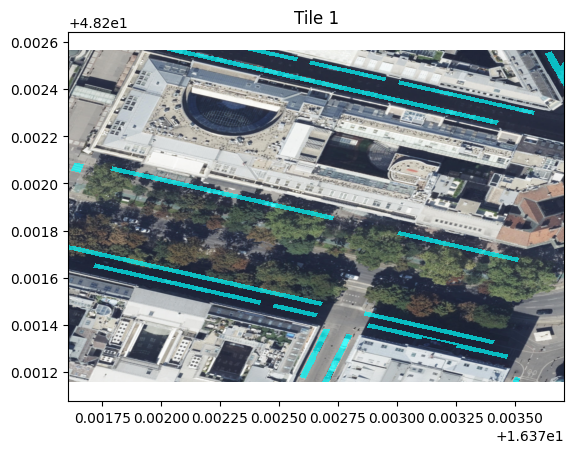

(<PIL.Image.Image image mode=RGB size=1024x1024>,
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 0    POLYGON ((16.37371 48.20116, 16.37371 48.20256...
 dtype: geometry)

In [34]:
ds.get_tile(1,plot=True)